<h1 align="center" style="line-height: 150%">Machine Learning - Group Project Final Submission<br>Online News Popularity</h1>

**Project Name:**<br>
Online News Popularity

**Group Number:**<br>
3

**Student IDs**:<br>
Sebastian Feit (45132)  
Arthur Meltendorf (49364)  
Julius Hildebrandt (50983)  
Johannes Tafferner (48487)

# Table of Contents

1. [**Introduction**](#1.-Introduction)  
    1.1 [What is the business problem we are aiming to solve?](#...)  
    1.2 [What is the machine learning problem?](#...)  
2. [**Data Preprocessing and Exploration**](#2.-Data-Preprocessing-and-Exploration)  
    2.1 [Loading the Data](#2.1-Loading-the-Data)  
    2.2 [Cleaning the Data](#...)  
    2.3 [Exploring the Data](#...)  
3. [**Feature and Target Engineering**](#3.-Feature-and-Target-Engineering)  
4. [**Logistic Regression Modeling**](#4.-Logistic-Regression-Modeling)  
    4.1 [First Logistic Regression without Hyperparameter Tuning](#4.1-First-Logistic-Regression-without-Hyperparameter-Tuning)  
5. [**Decision Tree Modeling**](#5.-Decision-Tree-Modeling)  
6. [**KNN Modeling**](#6.-KNN-Modeling)  
7. [**Random Forest Modeling (Bagging)**](#7.-Random-Forest-Modeling-(Bagging)) 
8. [**Neural Networks Modeling**](#8.-Neural-Networks-Modeling)
9. [**Ensemble Models (Boosting)**](#9.-Ensemble-Models-(Boosting))
10. [**Interpretability of Models**](#10.-Interpretability-of-Models)  
11. [**Final Model Selection**](#11.-Final-Model-Selection)  
12. [**Concluding Remarks**](#12.-Concluding-Remarks)  
13. [**Bibliography**](#13.-Bibliography)  

# 1. Introduction

### 1.1 What is the business problem we are aiming to solve?

#### The Business Problem:  
Since online publishers have **limited financial resources** to direct towards the marketing of their articles, they need to know in advance which articles have the **highest probability of becoming popular** to **spend the available budget most effectively** and gain the highest views and, thus, revenue.

#### Elaboration on the Relevance:  
It is well-known that (online) publishers have limited financial resources to spend on the marketing of their articles. Hence, it makes sense to direct the spending towards those articles that have the highest probability of becoming popular and receive a high number of views. This approach aims to increase the effectiveness of the marketing budget and should result in higher ad revenue due to more clicks.

We assume that the current budget is only sufficient to create full-scale marketing campaigns for the top 25% of written articles. Since the marketing campaign needs to start at the date of the release of the article, we need to know the probability of becoming popular in advance. That way, we can select the most promising articles to spend our marketing budget on and create a value for the publishing company.

The underlying assumption is that future click numbers can be estimated using available data from the past. A limitation of this could be that in today's world, the trends and preferences of online users are evolving rapidly and, therefore, past data may not have predictive power in the future.

### 1.2 What is the machine learning problem?

The machine learning problem we intend to solve is a binary classification of popular vs. unpopular articles based on a certain threshold.

Since we only have the financial resources to market the top **25%** of articles, the **precision** of our classification model at the estimated top 25% of articles should be at least **75%** (This is a **business assumption** as we assume a manual selection of articles could reach approximately 75% precision at the top 25% of articles). In our example, precision states the number of news articles correctly classified as being popular divided by the total number of news articles categorised as popular. With regards to type 1 and type 2 error, **type 2 error is economically worse** for the company since in this case a news article is categorised as being popular while it is not. As a matter of fact, marketing budget is spent on an article which is not going to generate the expected revenues in the future.

# 2. Data Preprocessing and Exploration

### 2.1 Loading the Data

The dataset has been retrieved from the <a href="https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity">UCI Machine Learning Repository.</a>

In [1]:
import pandas as pd

data = pd.read_csv('OnlineNewsPopularity.csv')

The feature names contain leading whitespaces which are removed in the following step.

In [2]:
data.columns = [col.strip() for col in data.columns]

### 2.2 Cleaning the Data

It can be seen in the code below that the dataset consists of **39,644 instances** and 61 columns of which **the last column, shares, refers to the variable of interest (target variable)**.

The first two variables (url & timedelta) refer to the url of retrieval and days between the article publication and the dataset acquisition and are of non-predictive nature. Hence, they will be removed from the DataFrame which leaves **58 predictive attributes**.

The column *Non-Null Count* in the table already reveals that **no data is missing**, neither of the features, nor the target. Therefore, no imputation or other dealing with missing values is needed.

In [3]:
data.info()
data.drop(labels = ['url', 'timedelta'], axis = 1, inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

As can be seen below, the dataset contains **no duplicates**.

In [4]:
data.duplicated().sum()

0

Looking at the statistical description below reveals **potential outliers**. The quartiles and min/max values show that in the features *n_unique_tokens, n_non_stop_words,* and *n_non_stop_unique_tokens* extremely high values on the top end can be found. Since these variables are ratios between 0 and 1, values such as 701, 1042, or 650 are errors in the data. This assumption is confirmed by plotting a box plot of those variables.

Stop words refer to words such as “a”, “the”, “is”, or “are” which are not carrying relevant information about the content.

In [5]:
# display a description of all 59 columns
pd.options.display.max_columns = data.shape[1]

data.describe()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
count    39644.000000      39644.000000     39644.000000      39644.000000   
mean        10.398749        546.514731         0.548216          0.996469   
std          2.114037        471.107508         3.520708          5.231231   
min          2.000000          0.000000         0.000000          0.000000   
25%          9.000000        246.000000         0.470870          1.000000   
50%         10.000000        409.000000         0.539226          1.000000   
75%         12.000000        716.000000         0.608696          1.000000   
max         23.000000       8474.000000       701.000000       1042.000000   

       n_non_stop_unique_tokens     num_hrefs  num_self_hrefs      num_imgs  \
count              39644.000000  39644.000000    39644.000000  39644.000000   
mean                   0.689175     10.883690        3.293638      4.544143   
std                    3.264816     11.332017        3.855141      8.309434   
min                    0.000000      0.000000        0.000000      0.000000   
25%                    0.625739      4.000000        1.000000      1.000000   
50%                    0.690476      8.000000        3.000000      1.000000   
75%                    0.754630     14.000000        4.000000      4.000000   
max                  650.000000    304.000000      116.000000    128.000000   

         num_videos  average_token_length  num_keywords  \
count  39644.000000          39644.000000  39644.000000   
mean       1.249874              4.548239      7.223767   
std        4.107855              0.844406      1.909130   
min        0.000000              0.000000      1.000000   
25%        0.000000              4.478404      6.000000   
50%        0.000000              4.664082      7.000000   
75%        1.000000              4.854839      9.000000   
max       91.000000              8.041534     10.000000   

       data_channel_is_lifestyle  data_channel_is_entertainment  \
count               39644.000000                   39644.000000   
mean                    0.052946                       0.178009   
std                     0.223929                       0.382525   
min                     0.000000                       0.000000   
25%                     0.000000                       0.000000   
50%                     0.000000                       0.000000   
75%                     0.000000                       0.000000   
max                     1.000000                       1.000000   

       data_channel_is_bus  data_channel_is_socmed  data_channel_is_tech  \
count         39644.000000            39644.000000          39644.000000   
mean              0.157855                0.058597              0.185299   
std               0.364610                0.234871              0.388545   
min               0.000000                0.000000              0.000000   
25%               0.000000                0.000000              0.000000   
50%               0.000000                0.000000              0.000000   
75%               0.000000                0.000000              0.000000   
max               1.000000                1.000000              1.000000   

       data_channel_is_world    kw_min_min     kw_max_min    kw_avg_min  \
count           39644.000000  39644.000000   39644.000000  39644.000000   
mean                0.212567     26.106801    1153.951682    312.366967   
std                 0.409129     69.633215    3857.990877    620.783887   
min                 0.000000     -1.000000       0.000000     -1.000000   
25%                 0.000000     -1.000000     445.000000    141.750000   
50%                 0.000000     -1.000000     660.000000    235.500000   
75%                 0.000000      4.000000    1000.000000    357.000000   
max                 1.000000    377.000000  298400.000000  42827.857143   

          kw_min_max     kw_max_max     kw_avg_max    kw_min_avg  \
count   39644.000000   3964

It can be seen below, that each of those variables only has one outlier far above the rest of the values. These **3 outliers will be removed**.

<AxesSubplot:>

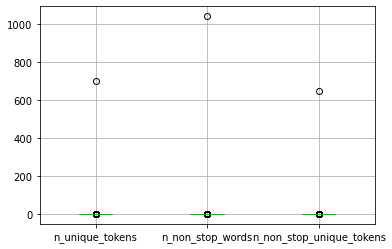

In [7]:
data[['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens']].boxplot()

Here we check for the index of the outliers. All 3 outliers have the same index position.

In [8]:
print(data.index[data['n_unique_tokens'] > 1].tolist())
print(data.index[data['n_non_stop_words'] > 1].tolist())
print(data.index[data['n_non_stop_unique_tokens'] > 1].tolist())

[31037]
[31037]
[31037]


It can be seen that all 3 outliers belonged to the same data point which is why we only **removed one instance**.

In [9]:
data = data.loc[(data['n_unique_tokens'] <= 1) &\
                (data['n_non_stop_words'] <= 1) &\
                (data['n_non_stop_unique_tokens'] <= 1)]
data.shape

(39643, 59)

Another problem with our data could emerge from the multicollinearity between the seven variables for each day of the week. Hence, the first variable, ***weekday_is_monday* is dropped**. Even though multicollinearity is no problem in Decision Trees, we decided to remove multicollinearity from the entire dataset so that Decision Tree based models can, e.g., also be used to evaluate feature importance. 

In [10]:
data.drop(labels = ['weekday_is_monday'], axis = 1, inplace = True)
data.shape

(39643, 58)

The same needs to be checked for the features that identify the channel in which the article is published (e.g. lifestyle or tech). It can be seen that these channel variables are **not collectively exhaustive** like the weekday variables and hence may not pose a problem of multicollinearity.

In [11]:
data.loc[(data['data_channel_is_lifestyle'] == 0) &\
         (data['data_channel_is_entertainment'] == 0) &\
         (data['data_channel_is_bus'] == 0) &\
         (data['data_channel_is_socmed'] == 0) &\
         (data['data_channel_is_tech'] == 0) &\
         (data['data_channel_is_world'] == 0)].shape

(6134, 58)

### 2.3 Data Exploration

All features as well as the target variable are already numerical data types such as float or int. Yet, not all 57 features are numerical. We looked at the dataset and found that all variables that are categorical include either the *word* week or *data_channel*.

The following features are of **categorical** nature and, if required, are already one-hot encoded.

In [12]:
categorical_features = [feature for feature in data.columns\
                        if ('data_channel' in feature) or\
                        ('week' in feature)]
categorical_features

['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend']

The following features are of **numerical** nature.

In [13]:
numerical_features = [feature for feature in data.columns if\
                     feature not in categorical_features]

# the target variable "shares" is still in the list and must be removed

del numerical_features[-1]

The following shows the **frequency distribution of the categorical variables**.

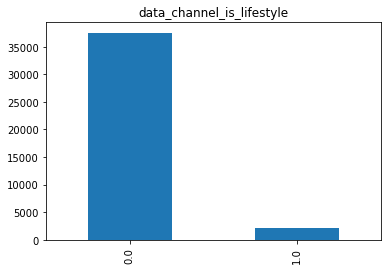

Frequency:
0.0    0.947052
1.0    0.052948
Name: data_channel_is_lifestyle, dtype: float64



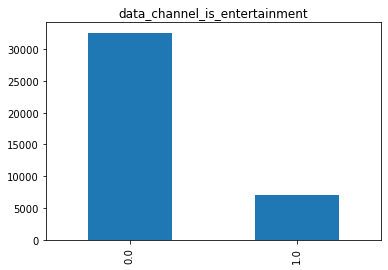

Frequency:
0.0    0.822011
1.0    0.177989
Name: data_channel_is_entertainment, dtype: float64



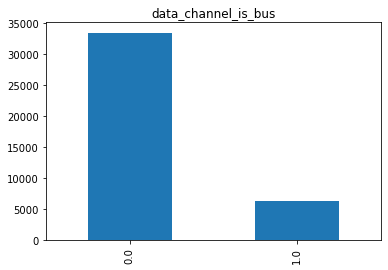

Frequency:
0.0    0.842141
1.0    0.157859
Name: data_channel_is_bus, dtype: float64



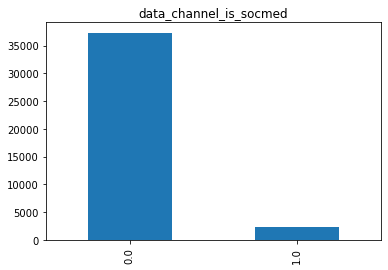

Frequency:
0.0    0.941402
1.0    0.058598
Name: data_channel_is_socmed, dtype: float64



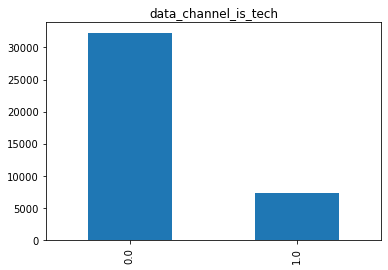

Frequency:
0.0    0.814696
1.0    0.185304
Name: data_channel_is_tech, dtype: float64



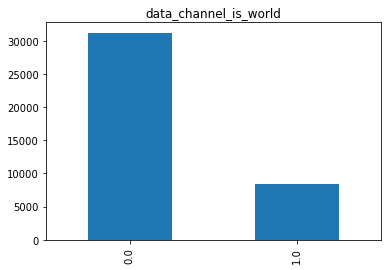

Frequency:
0.0    0.787428
1.0    0.212572
Name: data_channel_is_world, dtype: float64



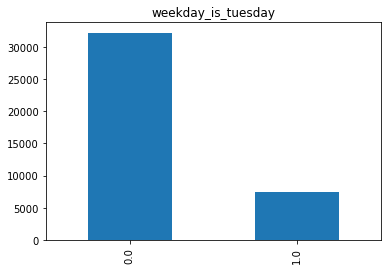

Frequency:
0.0    0.813611
1.0    0.186389
Name: weekday_is_tuesday, dtype: float64



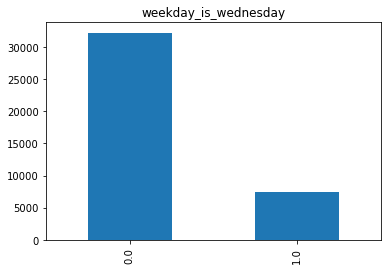

Frequency:
0.0    0.812451
1.0    0.187549
Name: weekday_is_wednesday, dtype: float64



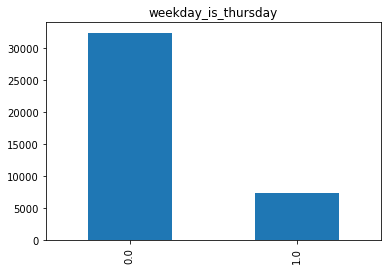

Frequency:
0.0    0.816689
1.0    0.183311
Name: weekday_is_thursday, dtype: float64



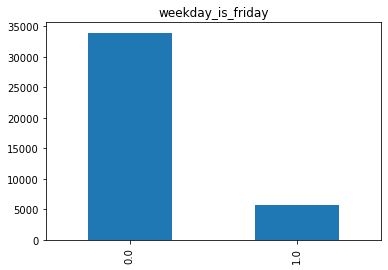

Frequency:
0.0    0.856192
1.0    0.143808
Name: weekday_is_friday, dtype: float64



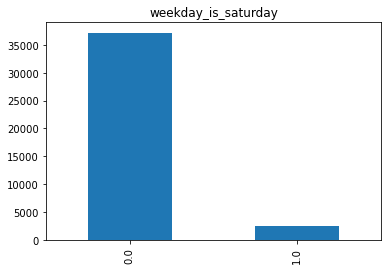

Frequency:
0.0    0.938123
1.0    0.061877
Name: weekday_is_saturday, dtype: float64



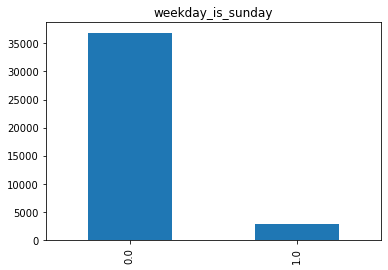

Frequency:
0.0    0.930959
1.0    0.069041
Name: weekday_is_sunday, dtype: float64



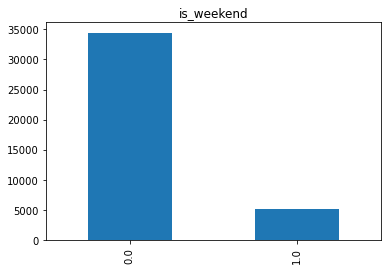

Frequency:
0.0    0.869082
1.0    0.130918
Name: is_weekend, dtype: float64



In [14]:
import matplotlib.pyplot as plt

for feature in categorical_features:
    data[feature].value_counts().plot(kind='bar')
    plt.title(feature)
    plt.show()
    print(f'Frequency:\n{data[feature].value_counts(normalize=True)}\n')

The following shows the **distribution of the numerical variables**.

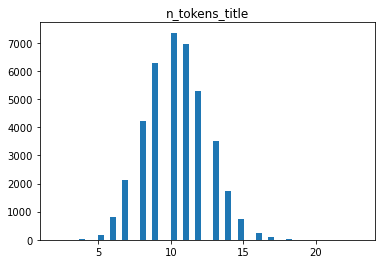

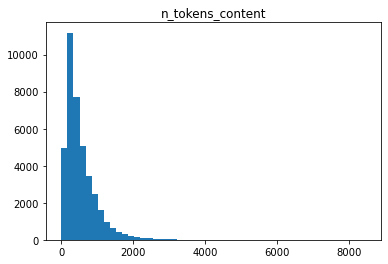

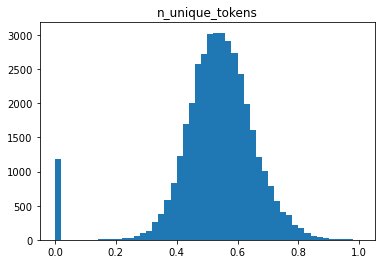

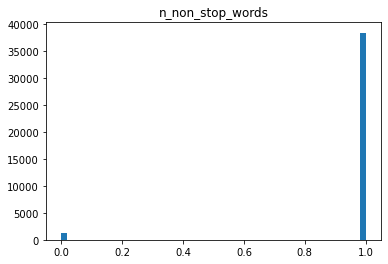

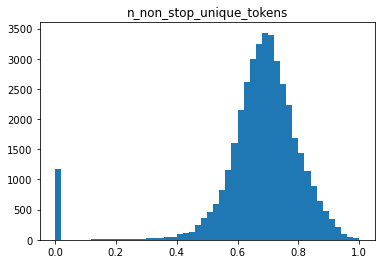

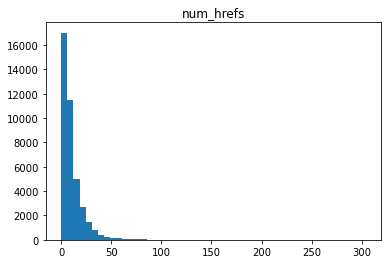

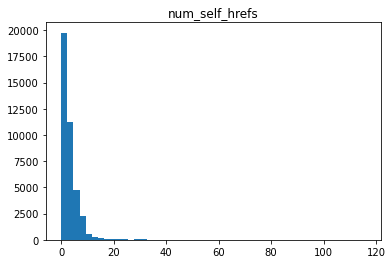

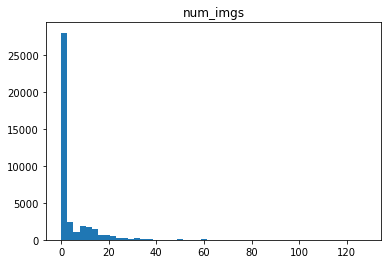

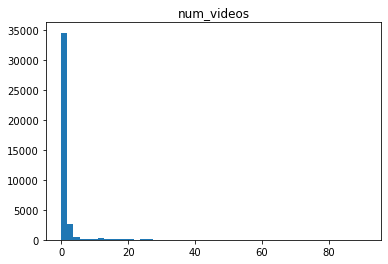

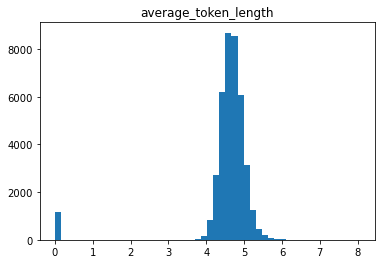

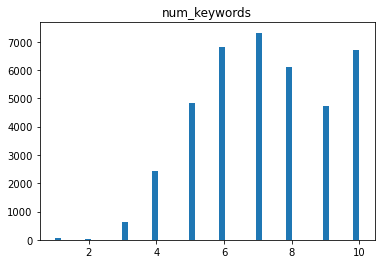

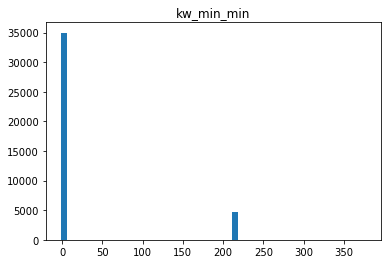

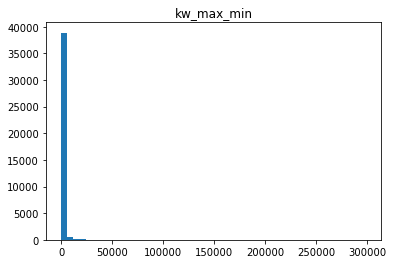

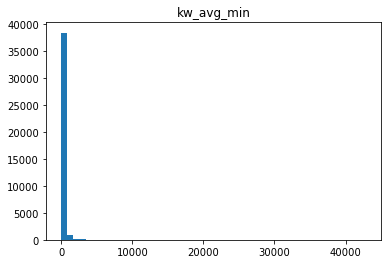

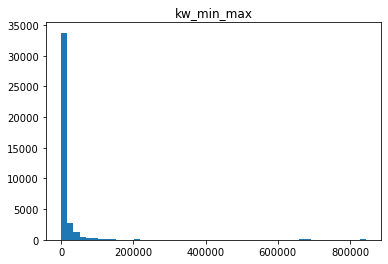

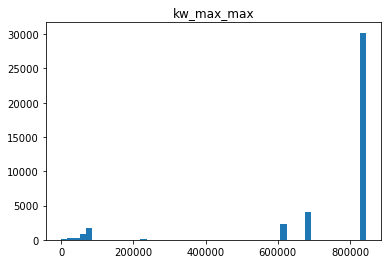

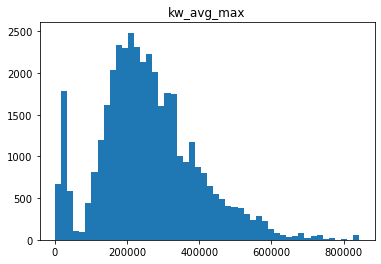

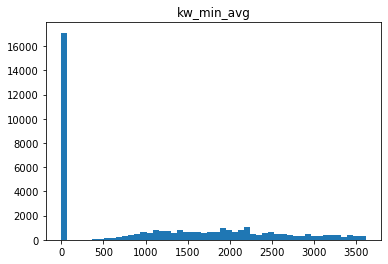

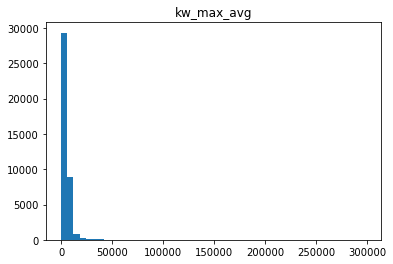

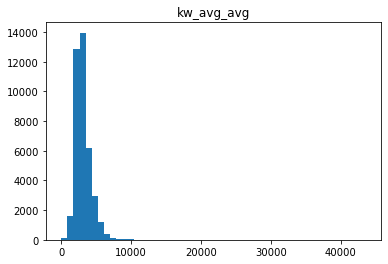

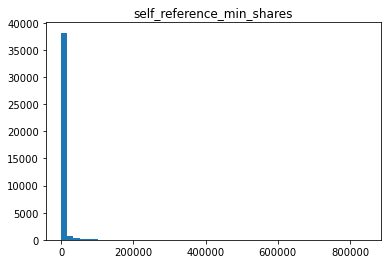

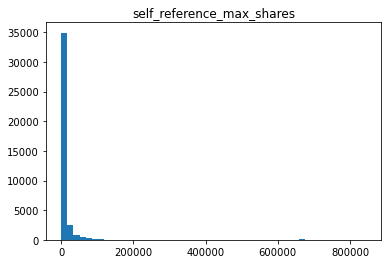

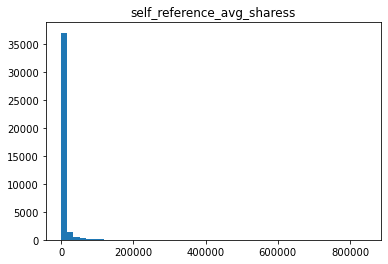

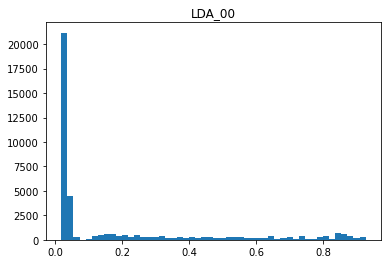

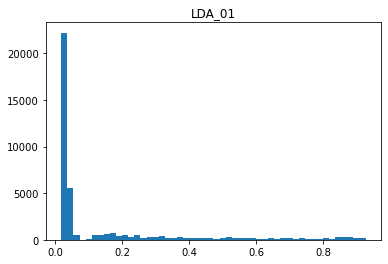

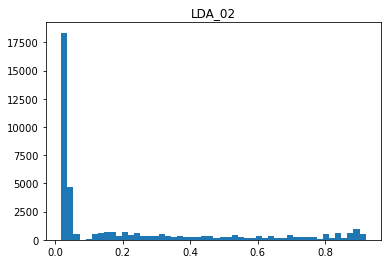

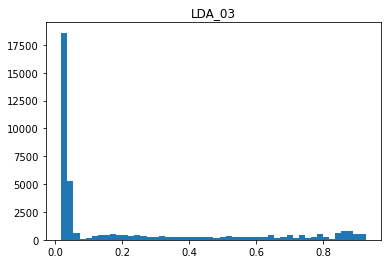

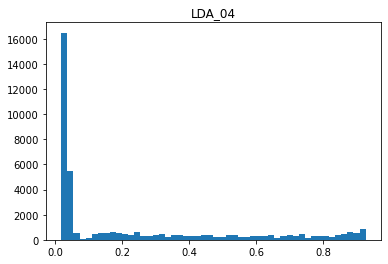

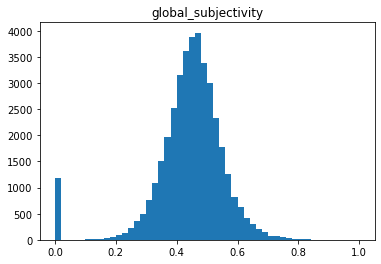

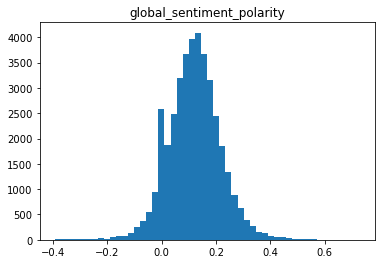

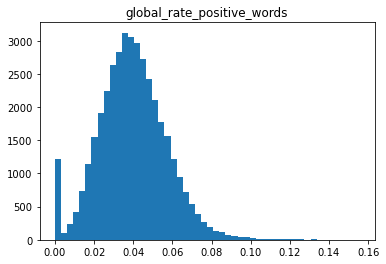

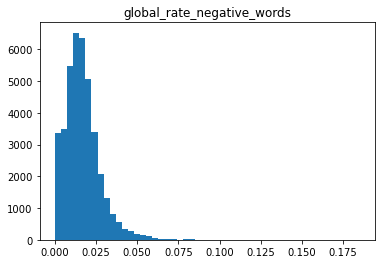

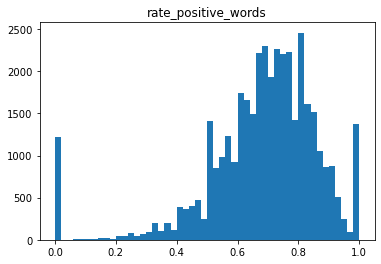

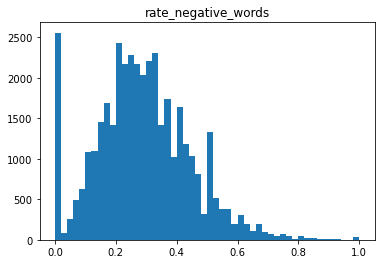

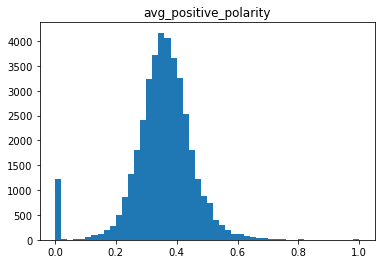

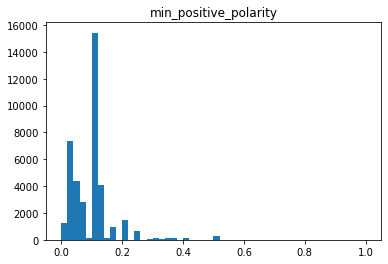

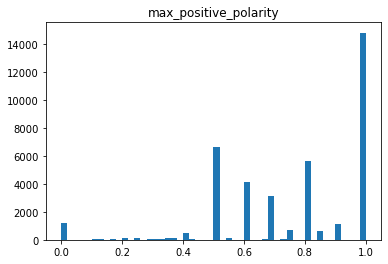

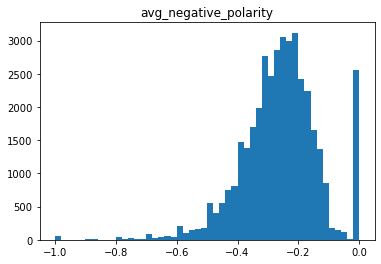

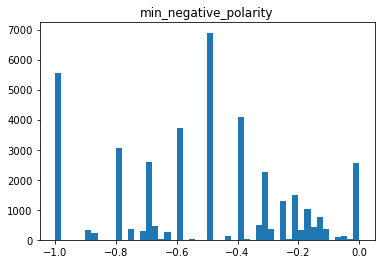

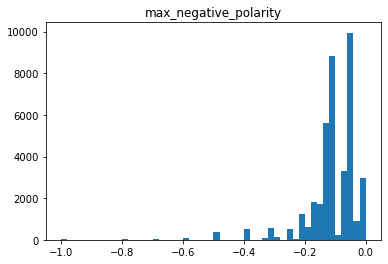

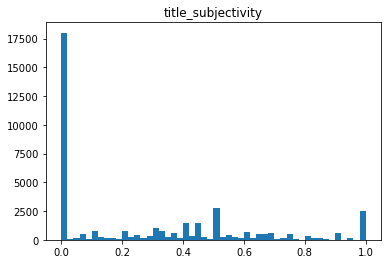

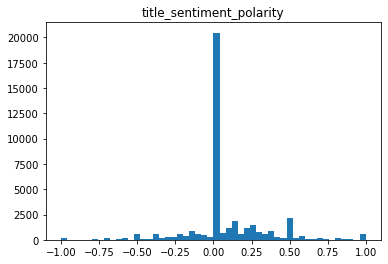

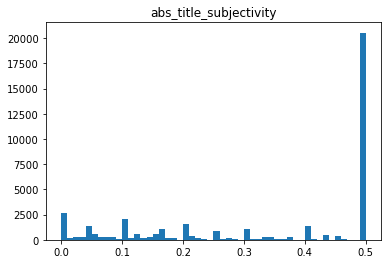

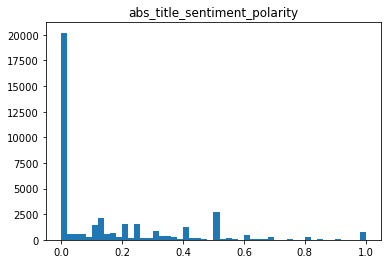

In [15]:
for feature in numerical_features:
    plt.hist(data[feature], bins=50)
    plt.title(feature)
    plt.show()

These distributions again reveal some outliers among pretty gaussian distributions which we might want to remove if we assume that these outliers are errors and not legitimate values.

A rate of 0 unique words, non-stop words, and unique non-stop words in the content is unplausible and these instances will be removed. The same holds true for the instances that show a 0 average length of the words in the content.

However, the outliers in the rate of positive/negative words as well as the outliers in the polarity and subjectivity features may be plausible as there may be articles that are not subjective at all or don't use positive words.

In [16]:
remove_outliers = True

if remove_outliers:
    
    initial_instances = data.shape[0]
    
    data = data.loc[(data['n_unique_tokens'] != 0) &\
                    (data['n_non_stop_words'] != 0) &\
                    (data['n_non_stop_unique_tokens'] != 0) &\
                    (data['average_token_length'] != 0)]
        
    num_removed_instances = initial_instances - data.shape[0]
    
    print(f'{num_removed_instances} instances have been removed.')

1181 instances have been removed.


The fact that only **1181 instances have been removed** shows that probably most of the instances with outliers had outliers in all variables mentioned above.

Below the **new distribution of the numerical variables**.
It can be seen that removing the outlying data points also removed outliers in other features such as global subjectivity. This reinforces our assumption that these values were errors and not legitimate outliers.

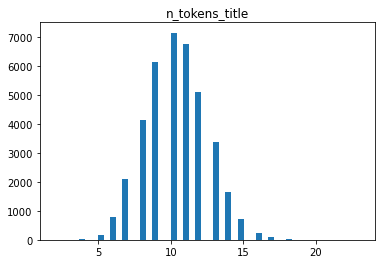

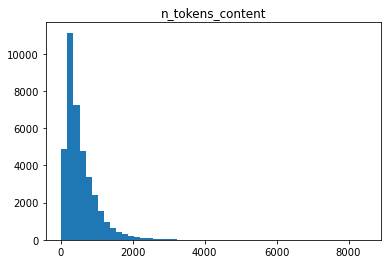

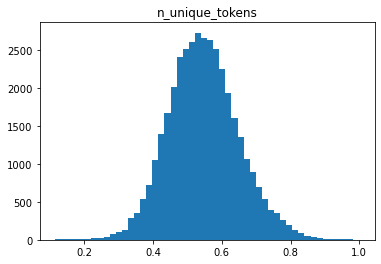

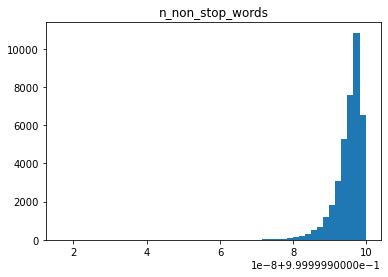

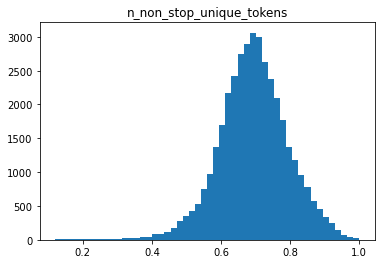

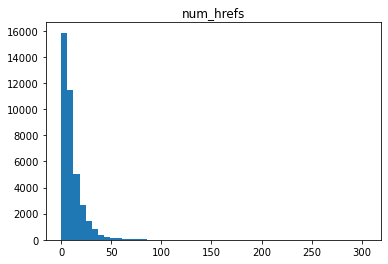

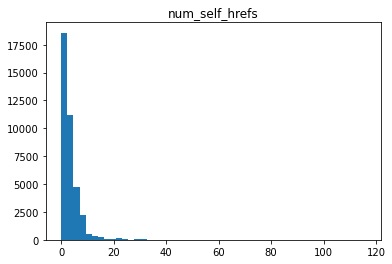

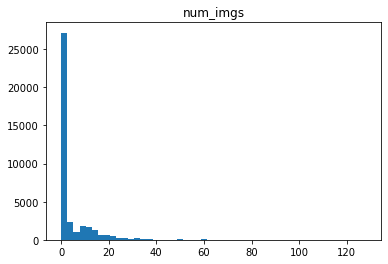

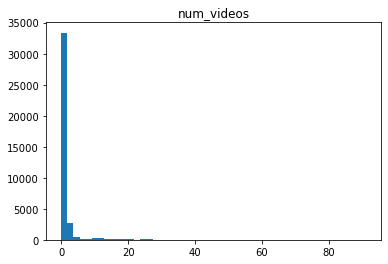

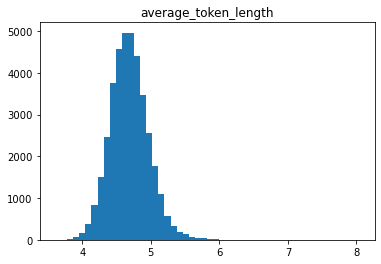

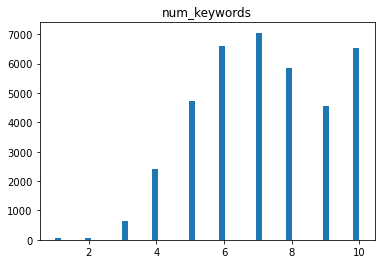

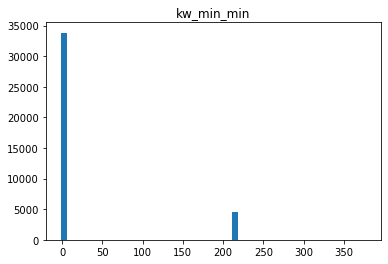

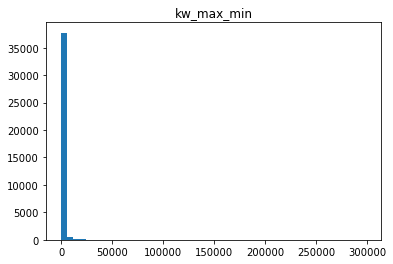

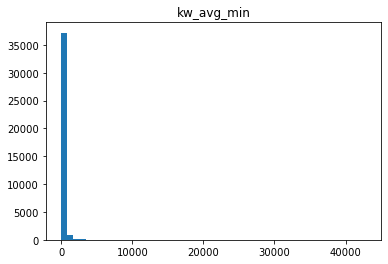

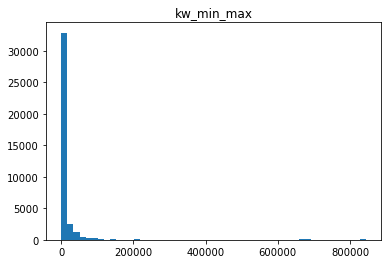

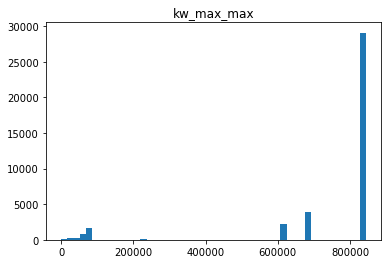

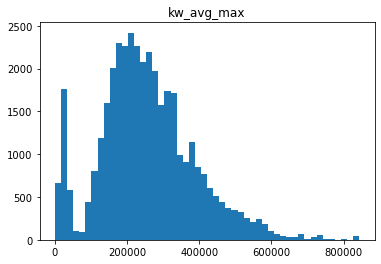

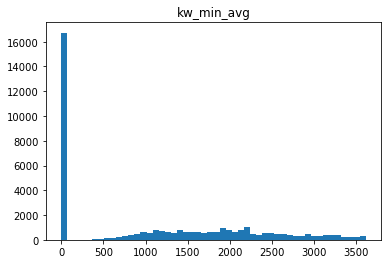

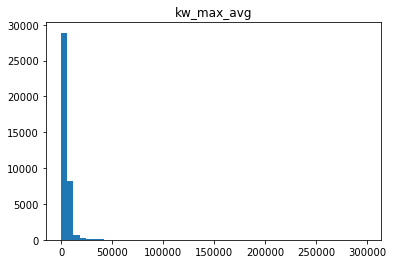

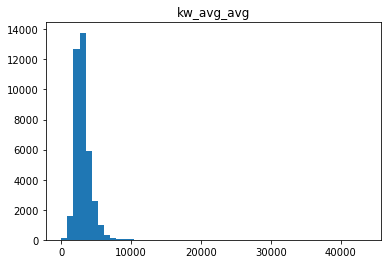

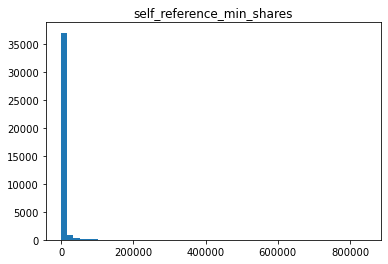

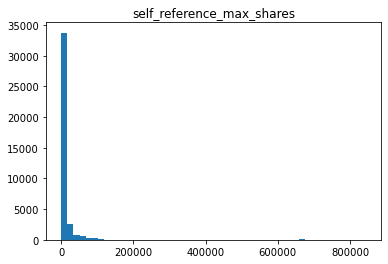

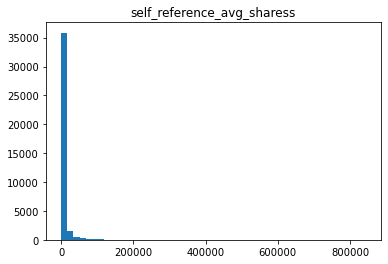

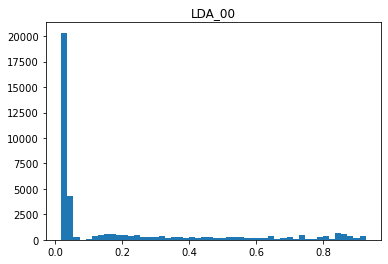

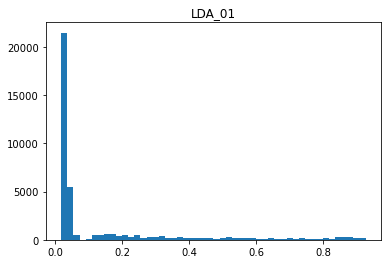

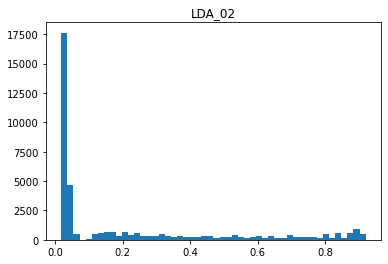

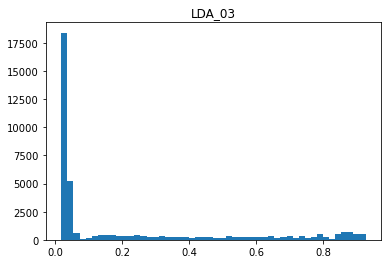

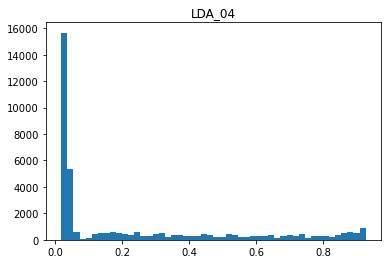

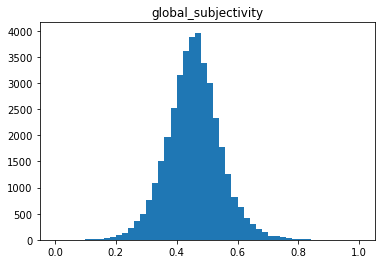

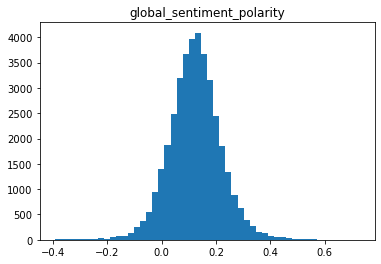

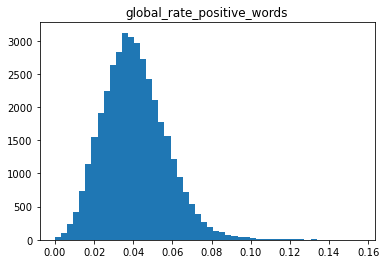

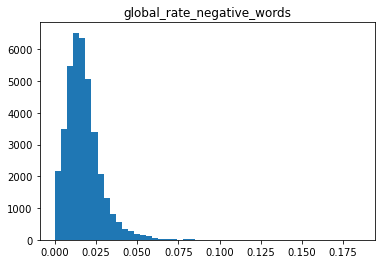

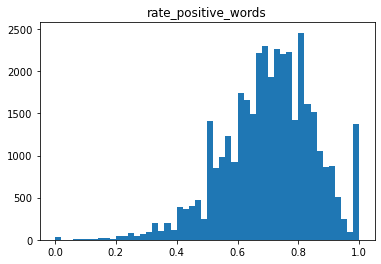

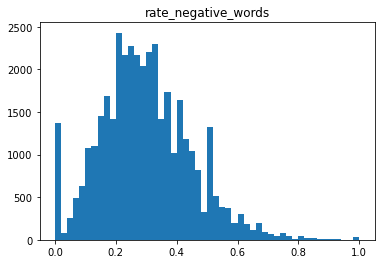

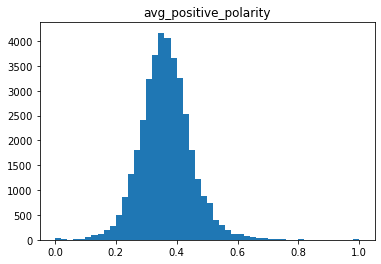

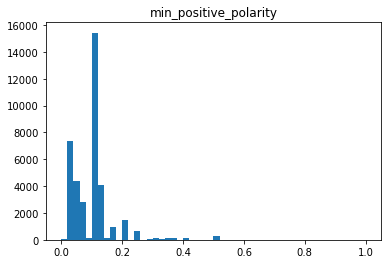

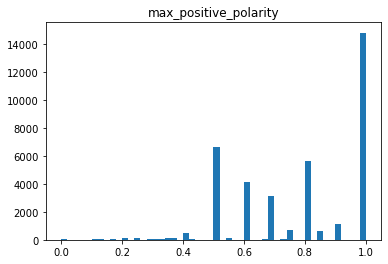

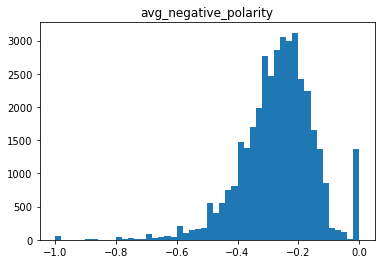

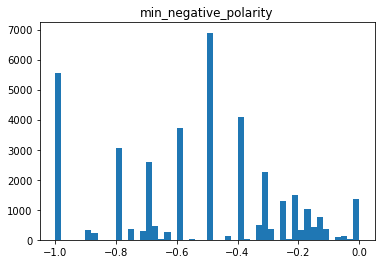

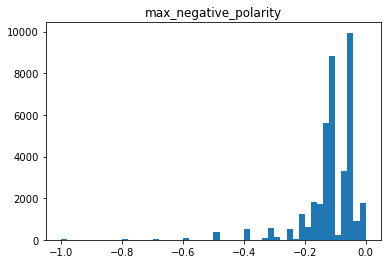

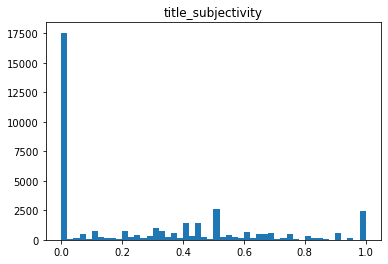

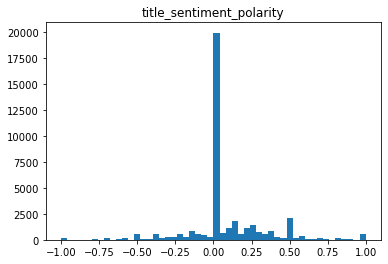

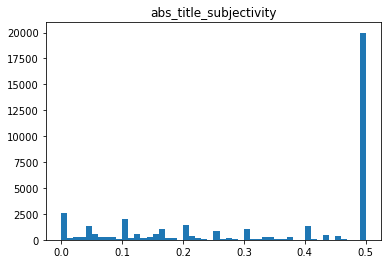

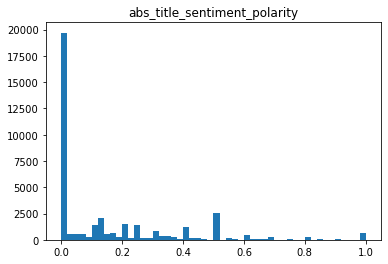

In [17]:
for feature in numerical_features:
    plt.hist(data[feature], bins=50)
    plt.title(feature)
    plt.show()

The target variable *shares* is a **discrete numerical variable** that displays how often the article has been shared. First, the entire distribution is shown and afterwards a zoomed view of the distribution.

The histograms reveal that the majority of articles have less than 4,000 shares but there are articles that have more than 800,00 shares. This is plausible as there is only a very limited amount of online articles that can attract such a degree of attention.

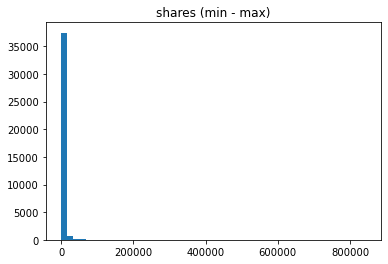

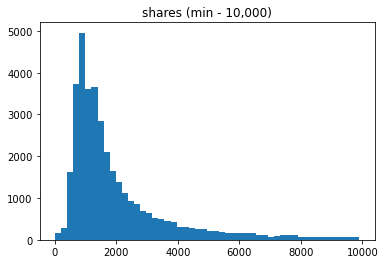

In [18]:
plt.hist(data['shares'], bins=50)
plt.title('shares (min - max)')
plt.show()

plt.hist(data['shares'].loc[data['shares'] < 10000], bins=50)
plt.title('shares (min - 10,000)')
plt.show()

The table below shows that exactly half of the articles have less or equal to 1,400 shares. Due to the extremely far outliers, the standard deviation is very high at a level of 11,586.

In [19]:
data['shares'].describe()

count     38462.000000
mean       3355.294238
std       11586.112129
min           1.000000
25%         945.000000
50%        1400.000000
75%        2700.000000
max      843300.000000
Name: shares, dtype: float64

The boxplot below depicts the upper bound as 1.5 times the interquartile range between the lower and upper quartile. Hence, all values above ~5,000 are classified as outliers.

Given our domain knowledge, these outliers are actually legitimate values as explained before. This is due to the fact that a minor fraction of articles naturally arise to be extremely popular and far outside the e.g. 3-σ interval.

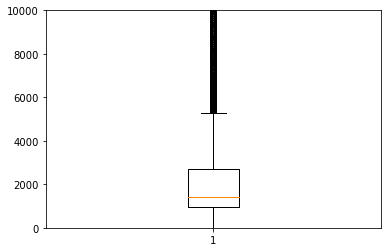

In [20]:
plt.boxplot(data['shares'])
plt.ylim(0, 10_000)
plt.show()

Next, we are going to depict the **correlation between the features and the target variable**. The values are sorted from the highest to the lowest correlation.

It can be seen that the variable *kw_avg_avg* has the highest correlation with the target variable. This variable shows the average number of shares of the average keyword for the respective article.

In [21]:
correlations = data.corr()['shares'].sort_values(ascending = False)[1:]

The plot below visualizes the **5 highest and 5 lowest correlations** of the **features with the target variable**. The number of features to be shown can be adapted with the variable *num_highest_lowest*.

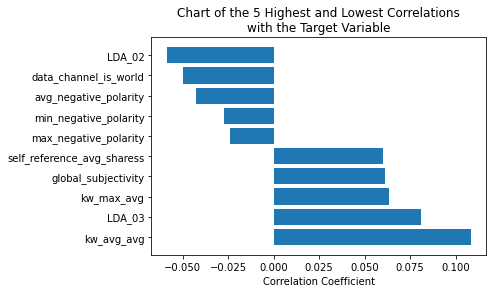

In [22]:
num_bars = 5

corr_values = list(correlations.values)[:num_bars] +\
list(correlations.values)[-num_bars:]

corr_labels = list(correlations.index)[:num_bars] +\
list(correlations.index)[-num_bars:]

plt.barh(range(len(corr_values)), corr_values, align='center')
plt.title(f'Chart of the {num_bars} Highest and Lowest Correlations\nwith the Target Variable')
plt.xlabel('Correlation Coefficient')
plt.yticks(range(len(corr_labels)), corr_labels)
plt.show()

The same can be done with **absolute correlation coefficients**.

In [23]:
abs_correlations = abs(data.corr()['shares']).sort_values(ascending = False)[1:]

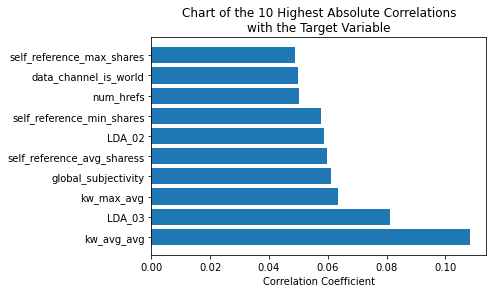

In [24]:
abs_corr_values = list(abs_correlations.values)[:num_bars * 2]
abs_corr_labels = list(abs_correlations.index)[:num_bars * 2]

plt.barh(range(len(abs_corr_values)), abs_corr_values, align='center')
plt.title(f'Chart of the {num_bars * 2} Highest Absolute Correlations\nwith the Target Variable')
plt.xlabel('Correlation Coefficient')
plt.yticks(range(len(abs_corr_labels)), abs_corr_labels)
plt.show()

If we wanted to restrict the number of features for our preliminary models, we could e.g. use the list of features with the highest correlation with the target variable.

All features now can be used in their original form and generally need not to be altered. Yet, as we explained in the beginning, we intend to reduce this dataset to solve classification problem and not a regression problem.

# 3. Feature and Target Engineering

**Main Considerations:**
1. The dataset we use for our analysis comes already with **one-hot encoded categorical variables**. 
2. Furthermore, the multicollinear features of the day of the week have already been reduced by one feature to **avoid the dummy variable trap**.
3. No missing data and, thus, **no imputation required**.
4. **Scaling** of the data will be done **within the grid search** of the best hyperparameters.
5. As we will sho in this section, we are going to transform the target variable into a binary variable such that we have approximately equal class distributions. Hence, **no data balancing will be required** in any model.
6. As of now, we deem further **feature transformation, aggregation, or discretization unnecessary**.

### Target Engineering

Yet, one important step before the classification models can be run is missing. As we explained in the beginning, we desire to solve a **classification problem** and not a regression problem. Currently, the **target variable** is of discrete numerical nature which is why it needs to be **transformed to a categorical variable**.

Fernandes, Vinagre, and Cortez (2015) use the median of 1,400 shares as the threshold for popular vs. unpopular articles. We will adapt this classification and hence consider all articles with more than 1,400 shares as popular and all articles with equal or less than 1,400 shares as unpopular. 

Since we are only able to advertise 25% of articles we will aim to adjust the threshold of the trained models so that we classify 25% of the articles in the test dataset as popular.

Depending on the performance of the our models, we reserve the right to adjust the threshold based on the business problem.

In [25]:
import numpy as np

popularity_threshold_shares = 1400

data['shares'] = np.where(data['shares'] > popularity_threshold_shares, 1, 0)

We can check again the distribution of the variable *shares* to confirm that the encoding was done correctly.

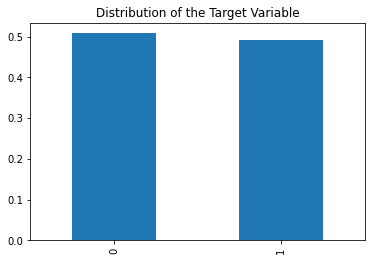

In [26]:
data['shares'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of the Target Variable')
plt.show()

After having converted the target variable to a **binary** variable, we need to **check the correlation with the other features again**. The correlation coefficients have changed slightly and the oder of the most correlated features did too. Hence, we will use the features that are most correlated with the binary version of our target variable for later analyses.

In [27]:
correlations = data.corr()['shares'].sort_values(ascending = False)[1:]

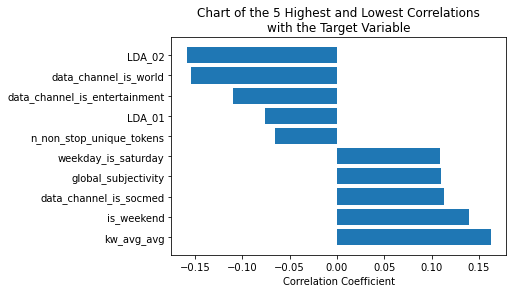

In [28]:
num_bars = 5

corr_values = list(correlations.values)[:num_bars] +\
list(correlations.values)[-num_bars:]

corr_labels = list(correlations.index)[:num_bars] +\
list(correlations.index)[-num_bars:]

plt.barh(range(len(corr_values)), corr_values, align='center')
plt.title(f'Chart of the {num_bars} Highest and Lowest Correlations\nwith the Target Variable')
plt.xlabel('Correlation Coefficient')
plt.yticks(range(len(corr_labels)), corr_labels)
plt.show()

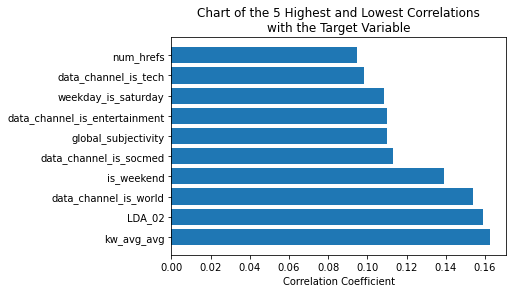

In [29]:
abs_correlations = abs(data.corr()['shares']).sort_values(ascending = False)[1:]

abs_corr_values = list(abs_correlations.values)[:num_bars * 2]
abs_corr_labels = list(abs_correlations.index)[:num_bars * 2]

plt.barh(range(len(abs_corr_values)), abs_corr_values, align='center')
plt.title(f'Chart of the {num_bars} Highest and Lowest Correlations\nwith the Target Variable')
plt.xlabel('Correlation Coefficient')
plt.yticks(range(len(abs_corr_labels)), abs_corr_labels)
plt.show()

### Feature Engineering

Before starting to initialize any model we need to **split the data into a training, validation, and test set** to avoid any data leakage. Since we have a sufficiently large amount of instances we choose to reserve **20%** of the dataset for the **validation set** as well as further **20%** for the final **test set**.

The validation set will be used to compare the different models we train with each other whereas the test set will only be used in the very last step fo evaluate the precision of the model we chose.

In [30]:
from sklearn.model_selection import train_test_split

X = data.drop(labels = ['shares'], axis = 1, inplace = False)
y = data['shares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [31]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(23076, 57)
(7693, 57)
(7693, 57)


# 4. Logistic Regression Modeling

In the following chapter, we will start with the modeling. Initially we will use some variations of the simplest classification algorithm: a **Logistic Regression**.

### 4.1 First Logistic Regression without Hyperparameter Tuning

We start with a simple logistic regression and standard scaling to start evaluating the precision.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_preprocessor, numerical_features),
    ('categorical', categorical_preprocessor, categorical_features)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state = 42))
])

The model above is a simple scaling without hyperparameter tuning or feature selection. Below, the precision of the model evaluated on the test set can be seen.

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      3868
           1       0.66      0.63      0.64      3825

    accuracy                           0.65      7693
   macro avg       0.66      0.65      0.65      7693
weighted avg       0.65      0.65      0.65      7693



/Users/johannestafferner/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


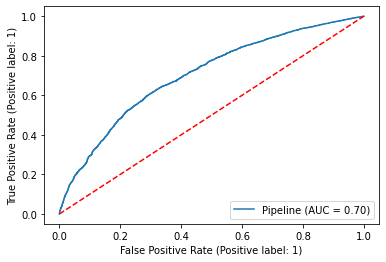

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import  plot_roc_curve

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

print(classification_report(y_val, y_pred))

plot_roc_curve(pipe, X_val, y_val)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Since we only target the 25% of articles, that are most probable to become popular, we evaluate the precision of the model again with a threshold that marks 25% of the articles as popular.

This already yields much better results with a **precision of 0.73**, yet falls short by a narrow margin of our 75% target precision.

Since we will use this methodology of adapting the threshold again for most of our models, we will now define a function that can be reused throughout this notebook.

In [36]:
def classification_report_adapted_threshold(X_val, y_val, model, quant = 0.75):
    
    y_pred_proba = model.predict_proba(X_val)
    new_threshold = pd.DataFrame(y_pred_proba)[1].quantile([quant]).values[0]
    y_pred_new_threshold = (y_pred_proba[:,1] >= new_threshold).astype(int)

    return(classification_report(y_val, y_pred_new_threshold))
    
print(classification_report_adapted_threshold(X_val, y_val, pipe))

              precision    recall  f1-score   support

           0       0.58      0.86      0.69      3868
           1       0.73      0.37      0.49      3825

    accuracy                           0.62      7693
   macro avg       0.65      0.62      0.59      7693
weighted avg       0.65      0.62      0.59      7693



### 4.2 Logistic Regression with Hyperparameter Tuning

Due to computational limitations of our computers we needed to restrict the number of hyperparameters to tune as well as the range of values of each hyperparameter. Hence, we also use the sklearn default 3-fold crossvalidation with the aim to reduce the required computational power. We used some standard values of the regularization strength to initialize our model since searching for more values would not have been computationally feasible.

In [38]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_preprocessor, numerical_features),
    ('categorical', categorical_preprocessor, categorical_features)
])

classifier = LogisticRegression(solver = 'liblinear', random_state = 42)
selector = RFE(classifier)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', classifier)
])

C = [0.01, 0.1, 1, 10]

scalers = [StandardScaler(), MinMaxScaler()]

param_grid = { 
    'preprocessor__numerical__scaler': scalers,
    'preprocessor__categorical__scaler': scalers,
    'selector__n_features_to_select': range(55, X_train.shape[1] + 1),
    'classifier__C': C,
    'classifier__penalty': ['l1', 'l2']
}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv = 3,
                    scoring = 'precision',
                    n_jobs = -1
                   )

pipe.get_params
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_tokens_title',
                                                                          'n_tokens_content',
                                                                          'n_unique_tokens',
                                                                          'n_non_stop_words',
                                                                          'n_non_stop_unique_tokens',
                                                                          'num_hrefs',
                                                                  

In [39]:
y_pred = grid.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      3868
           1       0.66      0.63      0.64      3825

    accuracy                           0.66      7693
   macro avg       0.66      0.65      0.65      7693
weighted avg       0.66      0.66      0.65      7693



In [40]:
print(classification_report_adapted_threshold(X_val, y_val, grid))

              precision    recall  f1-score   support

           0       0.58      0.86      0.69      3868
           1       0.73      0.36      0.49      3825

    accuracy                           0.62      7693
   macro avg       0.65      0.61      0.59      7693
weighted avg       0.65      0.62      0.59      7693



### 4.3 Logistic Regression with 10 most Correlated Features

In [105]:
X_restricted = data[abs_corr_labels]
y_restricted = data['shares']

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_restricted, y_restricted, test_size = 0.2, random_state = 42)
X_r_train, X_r_val, y_r_train, y_r_val = train_test_split(X_r_train, y_r_train, test_size = 0.25, random_state = 42)

In [107]:
preprocessor = StandardScaler()
classifier = LogisticRegression(solver = 'liblinear', random_state = 42)
selector = RFE(classifier)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', classifier)
])

C = range(1, 10)

scalers = [StandardScaler(), MinMaxScaler()]

param_grid = { 
    'preprocessor': scalers,
    'selector__n_features_to_select': range(8, X_r_train.shape[1] + 1),
    'classifier__C': C,
    'classifier__penalty': ['l1', 'l2']
}

grid_r = GridSearchCV(pipe,
                    param_grid,
                    cv = 3,
                    scoring = 'precision',
                    n_jobs = -1
                   )

grid_r.fit(X_r_train, y_r_train)
grid_r.best_params_

{'classifier__C': 6,
 'classifier__penalty': 'l1',
 'preprocessor': MinMaxScaler(),
 'selector__n_features_to_select': 8}

In [110]:
print(classification_report_adapted_threshold(X_r_val, y_r_val, grid_r))

              precision    recall  f1-score   support

           0       0.57      0.85      0.69      3868
           1       0.71      0.35      0.47      3825

    accuracy                           0.61      7693
   macro avg       0.64      0.60      0.58      7693
weighted avg       0.64      0.61      0.58      7693



### 4.4 Logistic Regression with Polynomial Features

Now we want to include polynoms of the features in our regression. Since we already have a large amount of features, we only use the 10 most correlated features for this regression. Apart from the polynoms, we use a similar model design as before.

In [284]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

X_r_train_poly = poly.fit_transform(X_r_train)
X_r_val_poly = poly.transform(X_r_val)
X_r_test_poly = poly.transform(X_r_test)
X_r_train_poly.shape

(23076, 65)

In [289]:
preprocessor = StandardScaler()
classifier = LogisticRegression(solver = 'liblinear', random_state = 42)
selector = RFE(classifier)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', classifier)
])

C = [0.01, 0.1, 1, 10]
scalers = [StandardScaler()]

param_grid = { 
    'preprocessor': scalers,
    'selector__n_features_to_select': range(X_r_train.shape[1] - 2, X_r_train.shape[1] + 1),
    'classifier__C': C,
    'classifier__penalty': ['l1', 'l2']
}

grid_r = GridSearchCV(pipe,
                    param_grid,
                    cv = 3,
                    scoring = 'precision',
                    n_jobs = 8,
                    verbose=5
                   )

grid_r.fit(X_r_train_poly, y_r_train)
grid_r.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'classifier__C': 0.01,
 'classifier__penalty': 'l2',
 'preprocessor': StandardScaler(),
 'selector__n_features_to_select': 9}

As seen in the classification report below, using polynomials of the 10 most correlated features even decreases out precision. This may either be due to the fact that the relationship between features and target variable is purely linear or because we were not able to test sufficient parameter combinations to find the optimal parameters in such a model.

In [291]:
print(classification_report_adapted_threshold(X_r_val_poly, y_r_val, grid_r))

              precision    recall  f1-score   support

           0       0.56      0.84      0.68      3868
           1       0.68      0.34      0.46      3825

    accuracy                           0.59      7693
   macro avg       0.62      0.59      0.57      7693
weighted avg       0.62      0.59      0.57      7693



# 5. Decision Tree Modeling

Next, we are going to fit Decision Trees to our dataset. As Decision Trees are not sensitive to the variance in the data, they do not require previous scaling.

### 5.1 Unrestricted Decision Tree

In [111]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [112]:
tree_1 = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

print(f'Number of nodes {tree_1.tree_.node_count}')
print(f'Depth of the tree {tree_1.tree_.max_depth}')

Number of nodes 7677
Depth of the tree 33


Due to the **extremely large amount of nodes**, there is a need of restricting the tree growth either by hyperparameter tuning or pruning.

### 5.2 Restricted Decision Tree (max_depth = 3)

Number of nodes is 15.
Depth of the tree is 3.


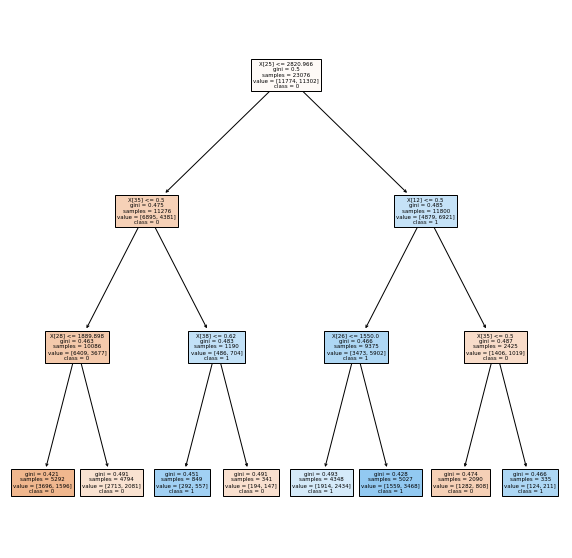

In [113]:
tree_2 = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

print(f'Number of nodes is {tree_2.tree_.node_count}.')
print(f'Depth of the tree is {tree_2.tree_.max_depth}.')

plt.figure(figsize=(10,10))
plot_tree(tree_2, class_names=['0','1'],filled=True)
plt.show()

### 5.3 Hyperparameter Tuning of Decision Tree with Randomized Search

In [114]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'max_depth': range(1, 21),
              'min_samples_leaf': range(1, 21),
              'criterion': ["gini", "entropy"]}

tree_3 = DecisionTreeClassifier()

random_search = RandomizedSearchCV(tree_3,
                                   parameters,
                                   n_iter = 10,
                                   random_state = 42,
                                   cv = 3,
                                   scoring = 'precision')

random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 21),
                                        'min_samples_leaf': range(1, 21)},
                   random_state=42, scoring='precision')

In [115]:
random_search.best_params_

{'min_samples_leaf': 14, 'max_depth': 7, 'criterion': 'entropy'}

In [116]:
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      3909
           1       0.62      0.69      0.65      3784

    accuracy                           0.64      7693
   macro avg       0.64      0.64      0.64      7693
weighted avg       0.64      0.64      0.64      7693

[CV 1/3] END classifier__C=1, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.632 total time=   0.1s
[CV 3/3] END classifier__C=1, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=8;, score=0.642 total time=   0.1s
[CV 3/3] END classifier__C=1, classifier__penalty=l2, preprocessor=MinMaxScaler(), selector__n_features_to_select=9;, score=0.637 total time=   0.1s
[CV 1/3] END classifier__C=1, classifier__penalty=l2, preprocessor=MinMaxScaler(), selector__n_features_to_select=10;, score=0.631 total time=   0.0s
[CV 2/3] END classifier__C=2, classifier__penalty=l2, preprocessor=Standar

[CV 3/3] END classifier__C=1, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=9;, score=0.642 total time=   0.0s
[CV 3/3] END classifier__C=1, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=9;, score=0.641 total time=   0.1s
[CV 1/3] END classifier__C=1, classifier__penalty=l2, preprocessor=MinMaxScaler(), selector__n_features_to_select=9;, score=0.631 total time=   0.1s
[CV 2/3] END classifier__C=1, classifier__penalty=l2, preprocessor=MinMaxScaler(), selector__n_features_to_select=9;, score=0.633 total time=   0.1s
[CV 1/3] END classifier__C=2, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.632 total time=   0.1s
[CV 2/3] END classifier__C=2, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.636 total time=   0.1s
[CV 1/3] END classifier__C=3, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_fea

[CV 3/3] END classifier__C=1, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.643 total time=   0.0s
[CV 2/3] END classifier__C=1, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=10;, score=0.635 total time=   0.1s
[CV 1/3] END classifier__C=2, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.632 total time=   0.1s
[CV 2/3] END classifier__C=2, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.636 total time=   0.0s
[CV 3/3] END classifier__C=2, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=9;, score=0.642 total time=   0.1s
[CV 1/3] END classifier__C=2, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=10;, score=0.631 total time=   0.1s
[CV 1/3] END classifier__C=3, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_f

[CV 1/3] END classifier__C=1, classifier__penalty=l1, preprocessor=MinMaxScaler(), selector__n_features_to_select=8;, score=0.631 total time=   0.1s
[CV 3/3] END classifier__C=1, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.644 total time=   0.0s
[CV 1/3] END classifier__C=1, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_features_to_select=9;, score=0.631 total time=   0.0s
[CV 2/3] END classifier__C=2, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=9;, score=0.636 total time=   0.0s
[CV 3/3] END classifier__C=2, classifier__penalty=l1, preprocessor=StandardScaler(), selector__n_features_to_select=9;, score=0.642 total time=   0.0s
[CV 3/3] END classifier__C=2, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n_features_to_select=8;, score=0.644 total time=   0.0s
[CV 1/3] END classifier__C=2, classifier__penalty=l2, preprocessor=StandardScaler(), selector__n

Similar to the Logistic Regression, we now set the probability threshold to a value such that only the top 25% of articles are predicted as popular. That way we aim to increase our precision on the range of articles that are most likely to become popular and are not wasting budget.

In [118]:
print(classification_report_adapted_threshold(X_val, y_val, random_search))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3868
           1       0.69      0.37      0.48      3825

    accuracy                           0.60      7693
   macro avg       0.63      0.60      0.58      7693
weighted avg       0.63      0.60      0.58      7693



As can be seen, we therewith increased the precision from 62% to **69%**. Yet, the precision score still lacks behind the one of the Logistic Regression.

### 5.3 Advanced Hyperparameter Tuning of Decision Tree with Grid Search

Now we are going to fit a more advanced Decision Tree with more hyperparameters using grid search. Due to computational limitations, we used 3-fold cross validation and a range of 9 until 39 in steps of 3 (since we saw before in 5.1 the maximum depth of 39). The other parameters to tune were set to include a broad range of magnitudes to check for different optimal parameters.

In [119]:
parameters = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 10, 50, 100, 500],
              'min_samples_leaf':[1, 10, 50, 100, 500],
              'max_depth': range(9, 40, 3)}

grid = GridSearchCV(DecisionTreeClassifier(),
                    parameters,
                    verbose = 1,
                    n_jobs = -1,
                    scoring = 'precision',
                    cv = 3
                   )

grid.fit(X_train, y_train)

Fitting 3 folds for each of 550 candidates, totalling 1650 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(9, 40, 3),
                         'min_samples_leaf': [1, 10, 50, 100, 500],
                         'min_samples_split': [2, 10, 50, 100, 500]},
             scoring='precision', verbose=1)

In [120]:
y_pred = grid.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64      3868
           1       0.64      0.67      0.65      3825

    accuracy                           0.65      7693
   macro avg       0.65      0.65      0.65      7693
weighted avg       0.65      0.65      0.65      7693



As before, we adjust the probability threshold of the Decision Tree. Again, the precision of our model is 71% which is an almost acceptable value considering our initial target of 75%.

In [122]:
print(classification_report_adapted_threshold(X_val, y_val, grid))

              precision    recall  f1-score   support

           0       0.58      0.84      0.69      3868
           1       0.71      0.38      0.50      3825

    accuracy                           0.61      7693
   macro avg       0.64      0.61      0.59      7693
weighted avg       0.64      0.61      0.59      7693



# 6. KNN Modeling

### 6.1 KNN with Hyperparameter Tuning

Since we have a very large number of features and instances, we try numbers of neighbours between 20 and 500.

In [124]:
from sklearn.neighbors import KNeighborsClassifier

preprocessor = StandardScaler()
classifier = KNeighborsClassifier(n_neighbors = 40)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

neighbours = range(20, 501, 20)

param_grid = { 
    'classifier__n_neighbors': neighbours,
}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv = 3,
                    scoring = 'precision',
                    n_jobs = -1
                   )

grid.fit(X_train, y_train)
grid.best_params_

{'classifier__n_neighbors': 480}

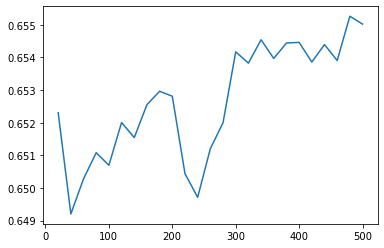

In [125]:
cv_results = pd.DataFrame(grid.cv_results_)

plt.plot(neighbours,
         cv_results['mean_test_score']
        )

In [126]:
y_pred = grid.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.71      0.66      3868
           1       0.66      0.57      0.61      3825

    accuracy                           0.64      7693
   macro avg       0.64      0.64      0.64      7693
weighted avg       0.64      0.64      0.64      7693



Adjusting the threshold, we yield a **precision of 71%**.

In [128]:
print(classification_report_adapted_threshold(X_val, y_val, grid))

              precision    recall  f1-score   support

           0       0.57      0.85      0.69      3868
           1       0.71      0.36      0.48      3825

    accuracy                           0.61      7693
   macro avg       0.64      0.61      0.58      7693
weighted avg       0.64      0.61      0.58      7693



### 6.2 KNN with Hyperparameter Tuning and Dimensionality Reduction (PCA)

Since the previous best parameters showed a value of 440 neighbors as the optimal values, we'll test a smaller number of values in that range to reduce computational effort.

While we were able to use recursive feature elimination when applying a Logistic Regression to our data, this is not possible with KNN since KNN doesn't provide information about feature importance (though we still could use Decision Trees or Logistic Regression for RFE). However, we try the approach of dimensionality reduction using PCA.

In [129]:
from sklearn.decomposition import PCA

preprocessor = StandardScaler()
classifier = KNeighborsClassifier(n_neighbors = 40)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('dimred', PCA()),
    ('classifier', classifier)
])

neigbours = range(380, 581, 20)
pca_components = range(40, X_train.shape[1] + 1, 5)

param_grid = { 
    'classifier__n_neighbors': neighbours,
    'preprocessor': [StandardScaler(), MinMaxScaler()],
    'dimred__n_components': pca_components
}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv = 3,
                    scoring = 'precision',
                    n_jobs = -1
                   )

grid.fit(X_train, y_train)
grid.best_params_

{'classifier__n_neighbors': 480,
 'dimred__n_components': 55,
 'preprocessor': StandardScaler()}

In [130]:
y_pred = grid.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.71      0.66      3868
           1       0.66      0.57      0.61      3825

    accuracy                           0.64      7693
   macro avg       0.64      0.64      0.64      7693
weighted avg       0.64      0.64      0.64      7693



In [132]:
print(classification_report_adapted_threshold(X_val, y_val, grid))

              precision    recall  f1-score   support

           0       0.57      0.85      0.69      3868
           1       0.71      0.36      0.48      3825

    accuracy                           0.61      7693
   macro avg       0.64      0.61      0.58      7693
weighted avg       0.64      0.61      0.58      7693



# 7. Random Forest Modeling (Bagging)

### 7.1 Simple Random Forest without Hyperparameter Tuning

In this section we only train a very simple Random Forest model to assess its precision. It can be seen below that when the probability threshold has been set correctly, the RF model performs the best with a **precision of 75%**.

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000,
                            oob_score = True,
                            n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True)

In [37]:
y_pred = rf.predict(X_val)

print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      3894
           1       0.66      0.67      0.67      3799

    accuracy                           0.67      7693
   macro avg       0.67      0.67      0.67      7693
weighted avg       0.67      0.67      0.67      7693



In [38]:
print(classification_report_adapted_threshold(X_val, y_val, rf))

              precision    recall  f1-score   support

           0       0.59      0.88      0.70      3868
           1       0.75      0.38      0.50      3825

    accuracy                           0.63      7693
   macro avg       0.67      0.63      0.60      7693
weighted avg       0.67      0.63      0.60      7693



### 7.2 Random Forest with Hyperparameter Tuning

Since Grid Search would be computationally too expensive, we use Randomized Search.

In [139]:
param_grid = {'n_estimators': range(200, 2001, 200),
             'max_depth': [10, 50, 100, None],
             'max_features': ['auto', 'sqrt'],
             'bootstrap': [True, False],
             'min_samples_leaf': [1, 2, 5, 10],
             'min_samples_split': [2, 5, 10]}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                              param_distributions = param_grid,
                              n_iter = 10,
                              cv = 3,
                              random_state = 42,
                              n_jobs = -1,
                              scoring = 'precision')

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=0.658 total time= 1.1min


/Users/johannestafferner/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV 2/3] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.661 total time=   9.2s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=0.663 total time= 1.1min
[CV 3/3] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.665 total time=   9.3s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=0.670 total time= 1.1min
[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400;, score=0.659 total time= 1.2min
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.655 total time= 1.3min
[CV 3/3] END bootstrap=False, max_depth=10, max_features=sqrt, m

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': range(200, 2001, 200)},
                   random_state=42, scoring='precision', verbose=5)

We can observe that even with hyperparameter tuning the best precision of the random forest on the validation set the equal to the precision without hyperparameter tuning.

In [140]:
y_pred = rf_random.predict(X_val)

print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      3905
           1       0.66      0.67      0.66      3788

    accuracy                           0.67      7693
   macro avg       0.67      0.67      0.67      7693
weighted avg       0.67      0.67      0.67      7693



In [141]:
print(classification_report_adapted_threshold(X_val, y_val, rf_random))

              precision    recall  f1-score   support

           0       0.59      0.88      0.70      3868
           1       0.75      0.38      0.50      3825

    accuracy                           0.63      7693
   macro avg       0.67      0.63      0.60      7693
weighted avg       0.67      0.63      0.60      7693

[CV 1/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.659 total time=  13.0s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.662 total time=  13.1s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.666 total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.666 total time=  12.7s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=

The lift curve shows a lift of approximately **1.5** at our aforementioned objective of **targeting the top 25%** of articles. This means that if we were to publish the 25% articles with the highest chance of becoming popular, we would have **1.5 times more popular articles** than if we chose at random.

<Figure size 504x504 with 0 Axes>

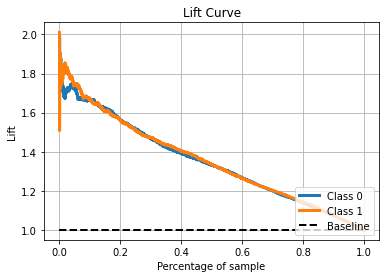

In [276]:
from scikitplot.metrics import plot_lift_curve

y_pred_prob = rf_random.predict_proba(X_val)

plt.figure(figsize=(7,7))
plot_lift_curve(y_val, y_pred_prob)
plt.show()

# 8. Neural Networks Modeling

### 8.1 Simple Neural Network without Hyperparameter Tuning

First, we are going to train one very simple neural network with no hyperparameter tuning and two hidden layers. For this, we also need to create a scaled train, validation, and test dataset.

In [187]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Having tried different approaches, we found that a sigmoid activation function in the output layer results in much better validation precision than using softmax. The aregularization strengths and initializers have been chose randomly but will be tuned in the consecutive step.

In [293]:
from tensorflow.keras import Sequential, layers, initializers, regularizers, losses, callbacks, optimizers
import tensorflow as tf

initializer = initializers.he_normal()
layer_neurons = 32

model = Sequential([
    
    #layers.Input(shape=(X_train.shape[1],)),
    #layers.Flatten(input_shape=(X_train.shape[1],)),
    
    layers.Dense(layer_neurons,
                 input_dim=X_train.shape[1],
                 activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001),
                 kernel_initializer=initializer),
    
    layers.Dense(layer_neurons,
                 activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001),
                 kernel_initializer=initializer),
    
    layers.Dense(1,
                 activation=tf.nn.sigmoid)
])


early_stop = callbacks.EarlyStopping(patience=3,
                                     monitor='Precision',
                                     restore_best_weights=True,
                                     mode='auto',
                                     baseline=None,
                                     verbose=1)

model.compile(optimizer='adam',
              metrics=['Precision'],
              loss=losses.BinaryCrossentropy())

tf.random.set_seed(42)
np.random.seed(42)

history = model.fit(X_train_scaled,
                    y_train,
                    epochs=50,
                    validation_split=0.25,
                    callbacks=[early_stop],
                    batch_size=1)

Train on 17307 samples, validate on 5769 samples
Epoch 1/50
17307/17307 [==============================] - 35s 2ms/sample - loss: 0.7071 - Precision: 0.6327 - val_loss: 0.6686 - val_Precision: 0.6229
Epoch 2/50
17307/17307 [==============================] - 40s 2ms/sample - loss: 0.6470 - Precision: 0.6436 - val_loss: 0.6427 - val_Precision: 0.6591
Epoch 3/50
17307/17307 [==============================] - 39s 2ms/sample - loss: 0.6370 - Precision: 0.6520 - val_loss: 0.6393 - val_Precision: 0.6490
Epoch 4/50
17307/17307 [==============================] - 41s 2ms/sample - loss: 0.6335 - Precision: 0.6517 - val_loss: 0.6373 - val_Precision: 0.6650
Epoch 00004: early stopping


It can be seen, that the final validation precision of **66%** score falls far behind most of the other methods we have presented so far. After the first period, the precision and loss doesn't improve much further.

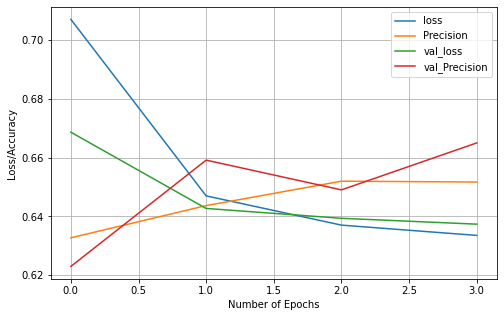

In [294]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

### 8.2 Neural Network with Hyperparameter Tuning

In [230]:
y_train_reshaped = y_train.reshape(y_train.shape[0], 1)
y_val_reshaped = y_val.reshape(y_val.shape[0], 1)
y_test_reshaped = y_test.reshape(y_test.shape[0], 1)

In [171]:
import keras_tuner as kt

def build_model(hp):
    
    layer_neurons_choice = [32, 64, 96, 128]
    regularization_strength_choice = [0.0001, 0.001, 0.01, 0.1]
    num_hidden_layers_choice = range(1, 5)
    learning_rate_choice = [1e-2, 1e-3, 1e-4]
    
    initializer = initializers.he_normal()
    
    model = Sequential()
    
    model.add(layers.Dense(hp.Choice('units_1', values=layer_neurons_choice),
                 input_dim=X_train_scaled.shape[1],
                 activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(hp.Choice('C_1', values=regularization_strength_choice)),
                 kernel_initializer=initializer))
    
    for i in range(hp.Choice('num_layers', values=num_hidden_layers_choice)):
        
        model.add(layers.Dense(units=hp.Choice(f'units_{i+1}', values=layer_neurons_choice),
                              activation=tf.nn.relu,
                              kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(hp.Choice(f'C_{i+1}', values=regularization_strength_choice))))
    
    model.add(layers.Dense(1,
                 activation=tf.nn.sigmoid))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=learning_rate_choice)),
                  metrics=['Precision'],
                  loss=losses.BinaryCrossentropy())
    
    return model

early_stop = callbacks.EarlyStopping(patience=3,
                                     monitor='Precision',
                                     restore_best_weights=True,
                                     mode='auto',
                                     baseline=None,
                                     verbose=1)

In [172]:
tuner = kt.Hyperband(
    build_model,
    objective='Precision',
    max_epochs=10
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Search space summary
Default search space size: 4
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
C_1 (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}
num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3, 4], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [175]:
tuner.search(X_train_scaled,
             y_train_reshaped,
             epochs=10,
             callbacks=[early_stop])

Trial 30 Complete [00h 01m 56s]
Precision: 0.49000000953674316

Best Precision So Far: 0.653293788433075
Total elapsed time: 00h 32m 45s
INFO:tensorflow:Oracle triggered exit


After almost 33 minutes of training, the model presents the following best parameters.

In [177]:
print('Best parameters found by the model:\n')
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

Best parameters found by the model:



{'units_1': 96,
 'C_1': 0.01,
 'num_layers': 2,
 'learning_rate': 0.0001,
 'units_2': 96,
 'C_2': 0.0001,
 'units_3': 96,
 'C_3': 0.001,
 'units_4': 96,
 'C_4': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

In [231]:
best_model = tuner.get_best_models()[0]
val_loss, val_acc = best_model.evaluate(X_val_scaled, y_val_reshaped)

7693/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

We can now observe, that even after extensive hyperparameter tuning and adaptation of the threshold, the **precision** of our model remains **well below other models** we have seen so far wit **68%**. This may be for example be due to out limited computational resources and resulting limitations in hyperparameter tuning and complexity of the model or due to the nature of the problem we are solving.

In [232]:
print('Validation accuracy:', val_acc)

Validation accuracy: 0.62977326


In [234]:
y_pred_proba = best_model.predict_proba(X_val_scaled)
new_threshold = pd.DataFrame(y_pred_proba).quantile([0.75]).values[0][0]

y_pred_new_threshold = (y_pred_proba[:] >= new_threshold).astype(int)
y_pred_new_threshold_reshaped = y_pred_new_threshold.reshape(y_pred_new_threshold.shape[0],)
print(classification_report(y_val_reshaped, y_pred_new_threshold_reshaped))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3868
           1       0.68      0.34      0.46      3825

    accuracy                           0.59      7693
   macro avg       0.62      0.59      0.57      7693
weighted avg       0.62      0.59      0.57      7693



# 9. Ensemble Models (Boosting)

### 9.1 XGBoost Model

As XGBoost is one of the most used ensemble methods, we start by implementing a simple XGB model with hyperparameter. As XGB is rather computationally expensive, only a randomized search cross validation with 20 iterations is feasible.

In [327]:
from xgboost import XGBClassifier
from scipy.stats import uniform as sp_uniform

# map stands for mean average precision,
# since precision is not available as an eval_metric with XGBoost

classifier = XGBClassifier(use_label_encoder=False, eval_metric='map')

pipe = Pipeline([
    ('classifier', classifier)
])

param_grid = {
    'classifier__eta': sp_uniform(loc=0.001, scale=0.299),
    'classifier__max_depth': range(5, 11),
    'classifier__n_estimators': range(100, 501, 100)
}

xgb_random_search = RandomizedSearchCV(pipe,
                    param_distributions = param_grid,
                    cv = 3,
                    n_iter=20,
                    scoring = 'precision',
                    n_jobs = 8
                   )

xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric='map',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                

In [328]:
print('The following are the best parameters:\n')

xgb_random_search.best_params_

The following are the best parameters:



{'classifier__eta': 0.09305436345703585,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 300}

After adjusting the threshold, XGBoost yields a **precision of 75%** on our validation set. This is the same precision score the RandomForest model achieved.

In [329]:
y_pred = xgb_random_search.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3868
           1       0.67      0.65      0.66      3825

    accuracy                           0.66      7693
   macro avg       0.66      0.66      0.66      7693
weighted avg       0.66      0.66      0.66      7693



In [330]:
print(classification_report_adapted_threshold(X_val, y_val, xgb_random_search))

              precision    recall  f1-score   support

           0       0.59      0.88      0.70      3868
           1       0.75      0.38      0.50      3825

    accuracy                           0.63      7693
   macro avg       0.67      0.63      0.60      7693
weighted avg       0.67      0.63      0.60      7693



### 9.2 LightGBM Model

We now use a similar approach as above, however using the LightGBM gradient boosting framework instead of XGB.

In [65]:
from sklearn.pipeline import Pipeline
from lightgbm.sklearn import LGBMClassifier
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

classifier = LGBMClassifier(objective='binary')

pipe = Pipeline([
    ('classifier', classifier)
])

# The used formula for the range of num_leaves is given by the
# LGBM documentation
param_grid = {
    'classifier__learning_rate': sp_uniform(loc=0.001, scale=0.299),
    'classifier__max_depth': range(5, 11),
    'classifier__num_leaves': range(2**5, 2**10),
    'classifier__n_estimators': range(100, 501, 100)
}


lgbm_random_search = RandomizedSearchCV(pipe,
                    param_distributions = param_grid,
                    cv = 3,
                    n_iter=50,
                    scoring = 'precision',
                    n_jobs = 6
                   )

lgbm_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('classifier',
                                              LGBMClassifier(objective='binary'))]),
                   n_iter=50, n_jobs=6,
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd785443890>,
                                        'classifier__max_depth': range(5, 11),
                                        'classifier__n_estimators': range(100, 501, 100),
                                        'classifier__num_leaves': range(32, 1024)},
                   scoring='precision')

It can be seen that the tuned LGBM classifier yields the **best precision after threshold adjustment so far**. With a value of **76%**, it lies even above the 75% achieved by XGB and RandomForest models.

In [66]:
from sklearn.metrics import classification_report

y_pred = lgbm_random_search.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      3868
           1       0.67      0.65      0.66      3825

    accuracy                           0.67      7693
   macro avg       0.67      0.67      0.67      7693
weighted avg       0.67      0.67      0.67      7693



In [67]:
print(classification_report_adapted_threshold(X_val, y_val, lgbm_random_search))

              precision    recall  f1-score   support

           0       0.59      0.88      0.71      3868
           1       0.76      0.38      0.51      3825

    accuracy                           0.63      7693
   macro avg       0.67      0.63      0.61      7693
weighted avg       0.67      0.63      0.61      7693



# 10. Interpretability of Models

WARNING: The LIME plots are resetted when the notebook is closed.

Being able to explain the prediction of our models (especially the best model that later will be implemented) is crucial to generate acceptance of decisions that are made on basis of the model's predictions. Hence, we especially focus on being able to explain particular missclassified data points of out best LGBM model.  

It is important to note that we are focusing in this interpretability chapter on the interpretability of our best model. Yet, the shown approaches can be used with almost any other model we have trained in this notebook.

### 10.1 Using LIME to Explain False Estimates of a Model

We will use LIME to explain the false estimate of the best model that we've found: LGBM.  
First, we will locate one sample of missclassified instances.

In [69]:
sample = X_val.copy(deep=False)
sample['y_val'] = y_val
sample['y_pred'] = y_pred
sample['y_pred_prob'] = lgbm_random_search.predict_proba(X_val)[:,1]

missclassified_instance = sample.loc[sample['y_val'] != sample['y_pred']].sample(1)
missclassified_instance

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
14518            10.0             470.0         0.534335               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  \
14518                  0.672662        4.0             2.0       0.0   

       num_videos  average_token_length  num_keywords  \
14518         1.0              4.255319           6.0   

       data_channel_is_lifestyle  data_channel_is_entertainment  \
14518                        0.0                            0.0   

       data_channel_is_bus  data_channel_is_socmed  data_channel_is_tech  \
14518                  0.0                     0.0                   0.0   

       data_channel_is_world  kw_min_min  kw_max_min  kw_avg_min  kw_min_max  \
14518                    0.0         4.0       506.0  122.666667     17700.0   

       kw_max_max  kw_avg_max   kw_min_avg  kw_max_avg   kw_avg_avg  \
14518    843300.0    579650.0  3083.833703  6212.55058  4421.556837   

       self_reference_min_shares  self_reference_max_shares  \
14518                     1900.0                     1900.0   

       self_reference_avg_sharess  ...  weekday_is_thursday  \
14518                      1900.0  ...                  0.0   

       weekday_is_friday  weekday_is_saturday  weekday_is_sunday  is_weekend  \
14518                0.0                  0.0                0.0         0.0   

         LDA_00    LDA_01    LDA_02    LDA_03    LDA_04  global_subjectivity  \
14518  0.033334  0.261653  0.033334  0.638344  0.033334             0.451233   

       global_sentiment_polarity  global_rate_positive_words  \
14518                    0.10526                    0.070213   

       global_rate_negative_words  rate_positive_words  rate_negative_words  \
14518                    0.019149             0.785714             0.214286   

       avg_positive_polarity  min_positive_polarity  max_positive_polarity  \
14518               0.372371                 0.0625                    1.0   

       avg_negative_polarity  min_negative_polarity  max_negative_polarity  \
14518              -0.500529                   -1.0              -0.071429   

       title_subjectivity  title_sentiment_polarity  abs_title_subjectivity  \
14518                 0.8                      -0.7                     0.3   

       abs_title_sentiment_polarity  y_val  y_pred  y_pred_prob  
14518                           0.7      0       1      0.51381  

[1 rows x 60 columns]

As seen below, the correct class of this data point would be 0, yet LightGBM predicted it to be class 1 (popular). However, the probability of class 1 was only 55%. Hence, this data point might have been classified correctly, if we had used the approach we mentioned already many times, namely to shift the probability threshold so that 25% of the articles will be classified as class 1. Hence, we will use this condition in the next step.

In [75]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True,
                                                   discretize_continuous=True,
                                                   random_state=42)

data_for_prediction = missclassified_instance.drop(columns=['y_val', 'y_pred', 'y_pred_prob'], inplace=False, axis=1).iloc[0]

exp_lime = explainer.explain_instance(data_for_prediction,
                                      predict_fn=lgbm_random_search.predict_proba,
                                      num_samples=500,
                                      num_features=5)

exp_lime.show_in_notebook(show_table = True, show_all= False)

Intercept 0.6061988498750867
Prediction_local [0.68559992]
Right: 0.6693120750539907


Sometimes LIME plots are not shown anymore after the notebook has been closed and reopened. Hence, we inserted a link to the picture below.

[10.1 Using LIME to Explain False Estimates of a Model.png](https://postimg.cc/VdshJDs6)

### 10.2 LIME Explanation of Missclassified Articles after Threshold Adjustment

As mentioned before, we will now use the same approach to find a data point that has been missclassified as class 1 while imposing the condition that it has to estimate a probability higher than the probability threshold that we calculated before.  

In [73]:
sample = X_val.copy(deep=False)
sample['y_val'] = y_val
sample['y_pred'] = y_pred
sample['y_pred_prob'] = lgbm_random_search.predict_proba(X_val)[:,1]

missclassified_instance = sample.loc[(sample['y_val'] == 0) & (sample['y_pred'] == 1) & (sample['y_pred_prob'] > new_threshold)].sample(1)
missclassified_instance

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
7721             9.0             242.0         0.647303               1.0   

      n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  \
7721                  0.827338        4.0             3.0       1.0   

      num_videos  average_token_length  num_keywords  \
7721         0.0              4.714876           8.0   

      data_channel_is_lifestyle  data_channel_is_entertainment  \
7721                        0.0                            0.0   

      data_channel_is_bus  data_channel_is_socmed  data_channel_is_tech  \
7721                  0.0                     0.0                   1.0   

      data_channel_is_world  kw_min_min  kw_max_min  kw_avg_min  kw_min_max  \
7721                    0.0         4.0      1400.0     505.875      3700.0   

      kw_max_max  kw_avg_max  kw_min_avg  kw_max_avg   kw_avg_avg  \
7721    690400.0    221075.0  2041.18705      5960.0  3224.497763   

      self_reference_min_shares  self_reference_max_shares  \
7721                    24000.0                    24000.0   

      self_reference_avg_sharess  ...  weekday_is_thursday  weekday_is_friday  \
7721                     24000.0  ...                  0.0                1.0   

      weekday_is_saturday  weekday_is_sunday  is_weekend    LDA_00    LDA_01  \
7721                  0.0                0.0         0.0  0.025047  0.025337   

        LDA_02    LDA_03    LDA_04  global_subjectivity  \
7721  0.422415  0.025086  0.502115             0.387707   

      global_sentiment_polarity  global_rate_positive_words  \
7721                   0.138017                    0.049587   

      global_rate_negative_words  rate_positive_words  rate_negative_words  \
7721                    0.008264             0.857143             0.142857   

      avg_positive_polarity  min_positive_polarity  max_positive_polarity  \
7721                0.35303                    0.1                    0.6   

      avg_negative_polarity  min_negative_polarity  max_negative_polarity  \
7721                   -0.6                   -1.0                   -0.2   

      title_subjectivity  title_sentiment_polarity  abs_title_subjectivity  \
7721                 0.1                       0.1                     0.4   

      abs_title_sentiment_polarity  y_val  y_pred  y_pred_prob  
7721                           0.1      0       1     0.669312  

[1 rows x 60 columns]

It can be seen below, that the model is quite certain about classifying this article as popular even though it is not. The features that contribute the most to this decision can be found below while the number of shown features in the LIME plot can easily be increases by adjusting the variable *num_explained_features*.

In [81]:
num_explained_features = 10


explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True,
                                                   discretize_continuous=True,
                                                   random_state=42)

data_for_prediction = missclassified_instance.drop(columns=['y_val', 'y_pred', 'y_pred_prob'], inplace=False, axis=1).iloc[0]

exp_lime = explainer.explain_instance(data_for_prediction,
                                      predict_fn=lgbm_random_search.predict_proba,
                                      num_samples=500,
                                      num_features=num_explained_features)

exp_lime.show_in_notebook(show_table = True, show_all = False)

Intercept 0.5787704654367914
Prediction_local [0.71007683]
Right: 0.6693120750539907


Sometimes LIME plots are not shown anymore after the notebook has been closed and reopened. Hence, we inserted a link to the picture below.

[10.2 LIME Explanation after Threshold Adjustment.png](https://postimg.cc/0r5jcK94)

### 10.3 SHAP Feature Importance

As our Random Forest model performs with 75% precision very good without requiring a lot of time to train, we decide to plot the feature importance of this model. For this purpose, we use the SHAP summary plot.  

As can be seen below, among the most important features of the RF model are kw_avg_avg, self_reference_min_shares, and kw_max_avg.

/Users/johannestafferner/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


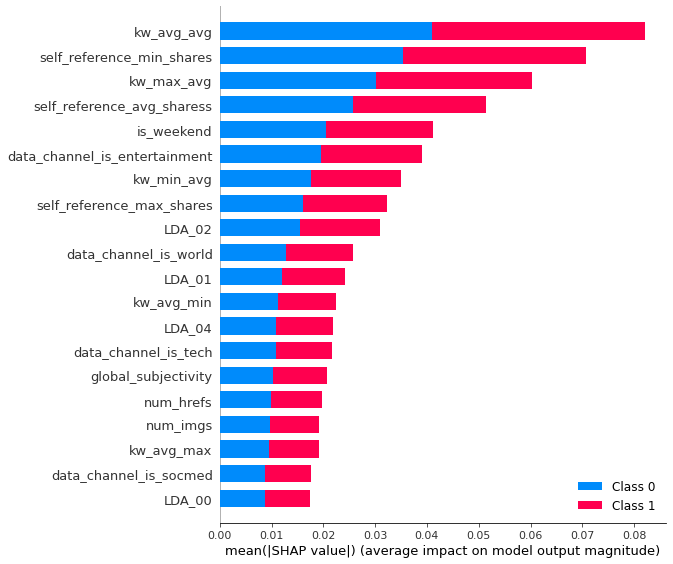

In [39]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_val, approximate=True)
shap.summary_plot(shap_values, X_val, plot_type='bar')

### 10.4 Partial Dependence Plots

In order to plot Partial Dependence Plots, we decided to obtain the permutation feature importance of our Random Forest model we used in the previous part to decide whihc features to plot. We select the 4 most important features as evaluated by the permutation_importance function for the PDPs.

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


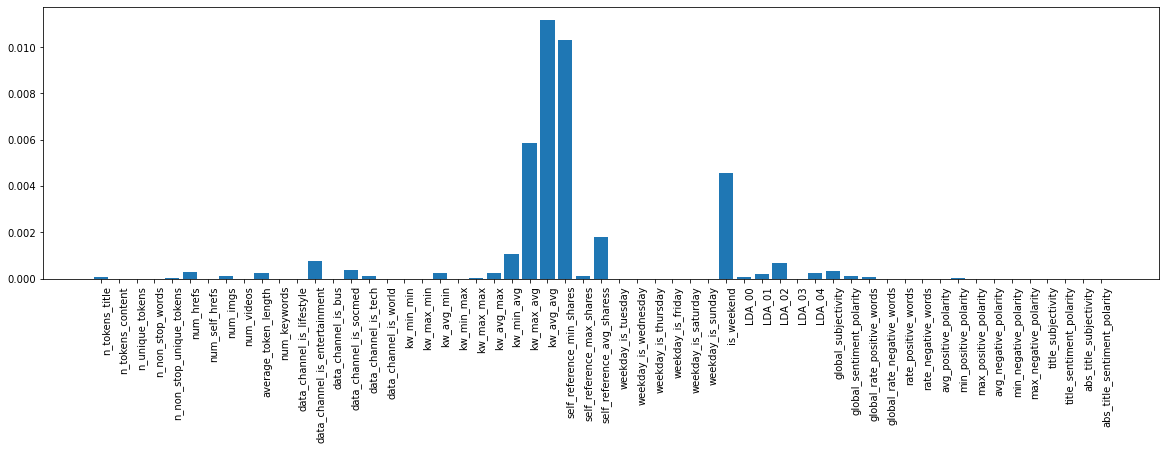

In [48]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(rf, X_train, y_train, n_repeats=5,n_jobs =-1, random_state=42)

fip = perm.importances_mean

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(fip)), fip, align="center")
ax.set(xticks=range(len(fip)), xticklabels=X_train.columns)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.show()

In [57]:
importance_df = pd.DataFrame({'importance': fip, 'feature': X_train.columns})
features = importance_df.sort_values(by='importance', ascending=False).head(4)['feature'].values

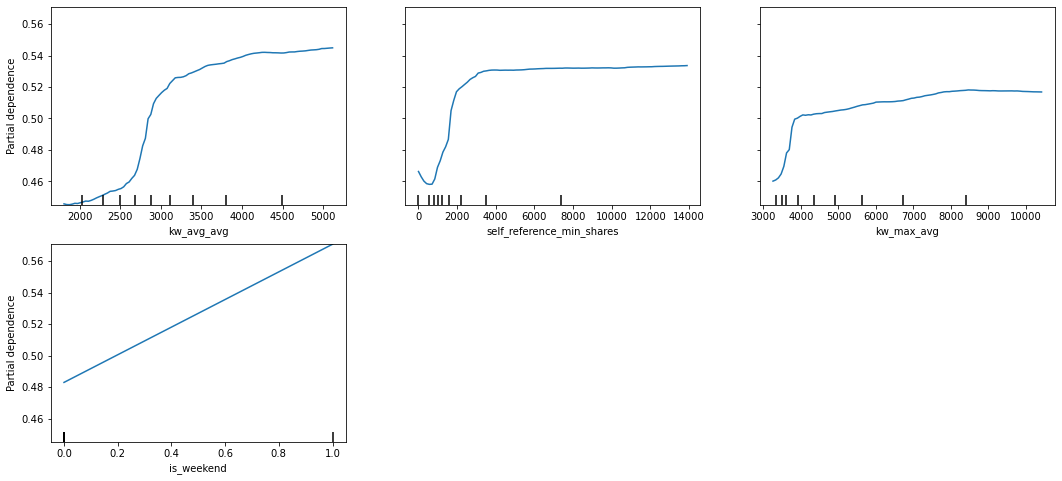

In [61]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(18,8))
PartialDependenceDisplay.from_estimator(rf, X_val, features, ax=ax)

### 10.5 PDP Interact Plot

Furthermore, we were wondering how the 2 most important features interact with each other. Hence, we plot the PDP interact plot using the Random Forest model as before.  

As can be seen below, the probability of being successfull for an article increases with both of the most important features.

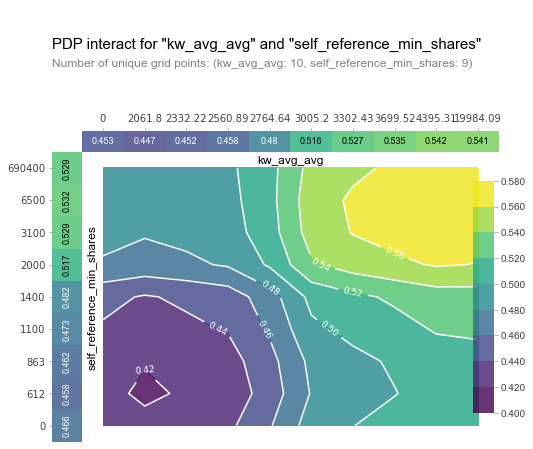

In [64]:
from pdpbox import pdp, get_dataset, info_plots

features_to_plot = features[:2]
inter1  =  pdp.pdp_interact(model=rf, dataset=X_val, model_features=X_val.columns, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', x_quantile=True, plot_pdp=True,  figsize=(8,8))
plt.show()

# 11. Final Model Evaluation

Lastly, we evaluate the model that performed the best on the validation set on the test set which it never has seen before. As seen below, the precision on the test set es **75%** and, hence, still meets out target of 75% even though it is 1% less than on the validation set.

In [87]:
print(classification_report_adapted_threshold(X_test, y_test, lgbm_random_search))

              precision    recall  f1-score   support

           0       0.59      0.87      0.71      3909
           1       0.75      0.38      0.50      3784

    accuracy                           0.63      7693
   macro avg       0.67      0.63      0.60      7693
weighted avg       0.67      0.63      0.61      7693



# 12. Concluding Remarks

After having trained 7 different types of classification models, each with a wide range of hyperparameters, we can come to a conclusion for our final project submission.

As we have seen, most models of which the hyperparameters have been tuned and the probability threshold has been adjusted, perform sufficiently well with precision scores of >=70%. Yet, the best precision score, which was achieved using a LightGBM model, has a **precision of 76%** on the validation set and **75% on the test set** and, hence, even exceeds our target of 75%. Thus, it is a good preliminary model to work with in order to classify articles as potentially popular or unpopular and is sufficiently efficient for us to promote our most interesting articles. We found it also interesting that the neural networks performed comparably bad even after extensive hyperparameter tuning. Furthermore, it is good to know that a simple logistic regression also perfroms with a precision of **73%**. Since Logistic Regressions are much easier to interpret and don't constitute a so-called *black-box model* it might be interesting to further improve the Logistic Regression Model since it could be a valid alternative to LGBM.

We are glad that after falling marginally behind our target with the midterm submission and a precision of 74%, we are now able to surpass our target precision using more sophisticated ensemble methods.
However, we would have liked to reach a higher precision especially because the dataset provided a broad range of features. It seems that some uncertainty is naturally given for the popularity of news as it is highly dependent on unmeasurable features that cannot be controlled for, e.g., current hypes, shares by certain persons of public interest, social networks dynamics or similar measures. In addition to that it is important to note that all articles that have been analyzed are from solely 1 website (https://mashable.com) and thus, it is questionable how the model generalizes for articles from websites with completely different audiences.

# 13. Bibliography

Fernandes, K., Vinagre, P., & Cortez, P. (2015, September). A proactive intelligent decision support system for predicting the popularity of online news. In Portuguese conference on artificial intelligence (pp. 535-546). Springer, Cham.